# Proyecto: Modelos No Lineales para Pronósticos MPST

## 1. Configuración inicial

En esta sección cargamos las librerías y ajustamos el entorno para el análisis, la visualización y el modelado de series de tiempo.



In [5]:
# 1. Configuración inicial: imports y entorno

import os
import datetime
import warnings
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import (
    Input, Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten,
    Dropout, BatchNormalization, TimeDistributed, ConvLSTM2D, Reshape
)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import optuna
import joblib

# Ajustes de visualización
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings("ignore")

# Semilla para reproducibilidad
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Gestión de memoria y GPU
gc.enable()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[0], 'GPU')


/Users/juanpabloblancolemus/PycharmProjects/Time-Series-Classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Carga y limpieza de datos (PJM)

Cargamos los precios horarios de PJM desde el CSV, parseamos la columna Date como índice y ordenamos cronológicamente. Luego renombramos las columnas para eliminar espacios y corregir un tipo (foecast → forecast). Finalmente separamos:

- *y*: precio zonal (zonal_comed_price)  
- *X*: pronósticos de carga (system_load_forecast, zonal_comed_load_forecast)

In [6]:
# Ruta y archivo
data_dir = "Zenodo-electricity-MPST/"
csv_path = os.path.join(data_dir, "PJM.csv")

In [7]:
# Carga con parseo de fecha (“Date”) como índice y ordenamiento
df_raw = (
    pd.read_csv(csv_path, parse_dates=["Date"], index_col="Date")
      .sort_index()
)

In [8]:
df_raw

Zonal COMED price  System load forecast  \
Date                                                           
2013-01-01 00:00:00          25.464211               85049.0   
2013-01-01 01:00:00          23.554578               82128.0   
2013-01-01 02:00:00          22.122277               80729.0   
2013-01-01 03:00:00          21.592066               80248.0   
2013-01-01 04:00:00          21.546501               80850.0   
...                                ...                   ...   
2018-12-24 19:00:00          29.761473               94939.0   
2018-12-24 20:00:00          27.897676               94035.0   
2018-12-24 21:00:00          26.405903               92923.0   
2018-12-24 22:00:00          24.646744               90970.0   
2018-12-24 23:00:00          23.980222               88037.0   

                     Zonal COMED load foecast  
Date                                           
2013-01-01 00:00:00                   11509.0  
2013-01-01 01:00:00                   10942.0  
2013-01-01 02:00:00                   10639.0  
2013-01-01 03:00:00                   10476.0  
2013-01-01 04:00:00                   10445.0  
...                                       ...  
2018-12-24 19:00:00                   11246.0  
2018-12-24 20:00:00                   11070.0  
2018-12-24 21:00:00                   10963.0  
2018-12-24 22:00:00                   10802.0  
2018-12-24 23:00:00                   10419.0  

[52416 rows x 3 columns]

In [9]:
# Renombrar columnas: quitar espacios, corregir typo y usar minúsculas con guiones bajos
rename_map = {
    " Zonal COMED price":            "zonal_comed_price",
    " System load forecast":         "system_load_forecast",
    " Zonal COMED load foecast":     "zonal_comed_load_forecast",
}
df_raw.rename(columns=rename_map, inplace=True)

In [10]:
y = df_raw["zonal_comed_price"]
X = df_raw[["system_load_forecast", "zonal_comed_load_forecast"]]

Ya tenemos con nombres más simples y legibles

### 3. Limpieza de columnas y definición de variables

Copiamos df_raw, renombramos las columnas para quitar espacios y corregir el typo en “foecast”. Luego separamos:

- *y*: precio (price)  
- *X*: pronósticos de carga (system_load_forecast, zonal_load_forecast)

In [11]:
# Hacer copia de seguridad
df = df_raw.copy()

In [12]:
# Renombrar columnas: quitar espacios y corregir typo
df.rename(columns={
    "zonal_comed_price":            "price",
    "system_load_forecast":         "system_load_forecast",
    "zonal_comed_load_forecast":     "zonal_load_forecast",
}, inplace=True)

In [13]:
# Definir target y features
y = df["price"]
X = df[["system_load_forecast", "zonal_load_forecast"]]

In [14]:
# Liberar df_raw que ya no se usará
del df_raw
gc.collect()

12

Ahora ya tenemos divididos nuestros datos en train y test con los nombres adecuados.

### 4. EDA: Series Temporales (Mercado PJM)

Mostramos:

1. *Todas las variables* en subplots independientes.  
2. *Precio zonal* (variable objetivo) en detalle.

*Observaciones clave*:
- Tendencia a largo plazo: crecimiento, decrecimiento o estabilidad.  
- Estacionalidad: patrones anuales, semanales o diarios.  
- Volatilidad: cambios en la amplitud de las oscilaciones.  
- Outliers o picos extremos.  
- Correlación visual entre precio y pronósticos de carga.

In [15]:
fig, axes = plt.subplots(
    nrows=df.shape[1], ncols=1,
    figsize=(18, 6 * df.shape[1]),
    sharex=True
)
fig.suptitle('Series Temporales - Mercado PJM', fontsize=16, y=0.92)

for ax, col in zip(axes, df.columns):
    ax.plot(df.index, df[col], label=col, linewidth=0.8)
    ax.set_ylabel(col)
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5)

axes[-1].set_xlabel('Fecha')
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

+ A ojo de buen cubero podemos observar que en `price` no hay una tendencia clara a largo plazo, parece que el nivel medio oscila en un valor estable, pero hay picos extremos. Veremos en uno individual para percibirlo mejor.

 + Vemos claros picos extremos, a lo que pensamos esto no necesariamente se debe a errores de datos, pero pudieron ser eventos climáticos extremos o características reales del mercado.

+ En `system_load_forcast`y `zonal_load_forecast` tampoco parece haber una tendencia a largo plazo.
+ Hay un patrón anual muy marcado, hay amplitudes más altas en meses de verano e invierno, lo cual hace mucho sentido. También a vista general vemos que también hay un patrón diario marcado.

+ Nos da una buena idea inicial para ver nuestros siguientes pasos, como la serie tiene picos extremos puede que no sea estacionaria. A lo mejor tendremos que hacer transformaciones para abordar este tema Mientras tanto, haremos una descomposición y análisis de estacionalidad más profundo.

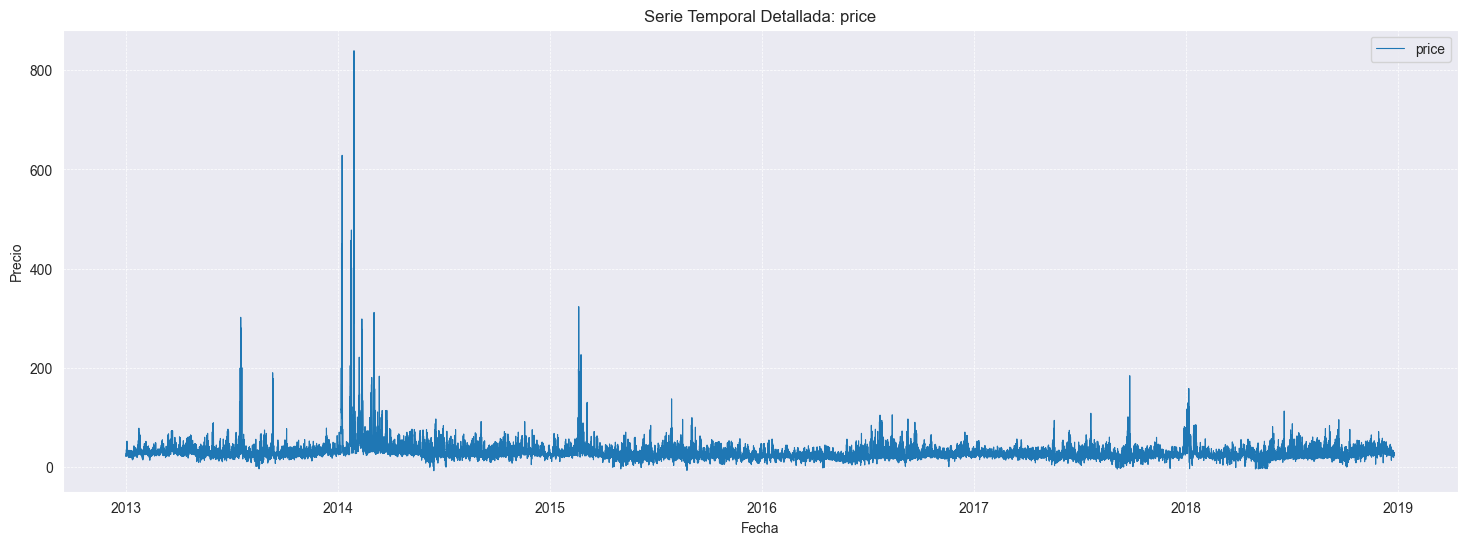

In [16]:
target_variable = "price"
feature_variables = X.columns
plt.figure(figsize=(18, 6))
plt.plot(df.index, df[target_variable], label=target_variable, linewidth=0.8)
plt.title(f'Serie Temporal Detallada: {target_variable}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 5. EDA: Descomposición STL

Aplicamos STL para dos escalas de estacionalidad:

- *Diaria* (periodo = 24)  
- *Semanal* (periodo = 168)  

Cada gráfico muestra:
1. *Trend* – la tendencia subyacente.  
2. *Seasonal* – el patrón estacional.  
3. *Residual* – el ruido restante.

Comparar ambas estacionalidades ayuda a identificar patrones en distintas escalas de tiempo.

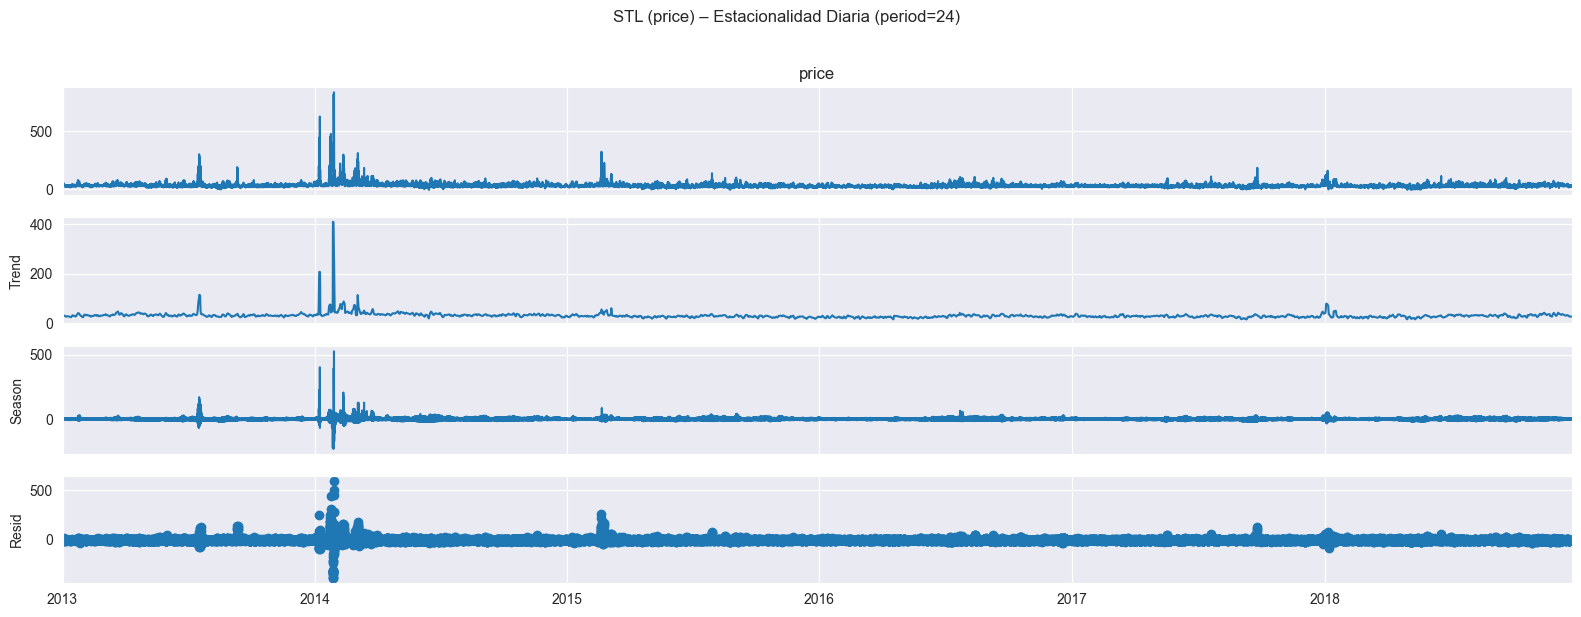

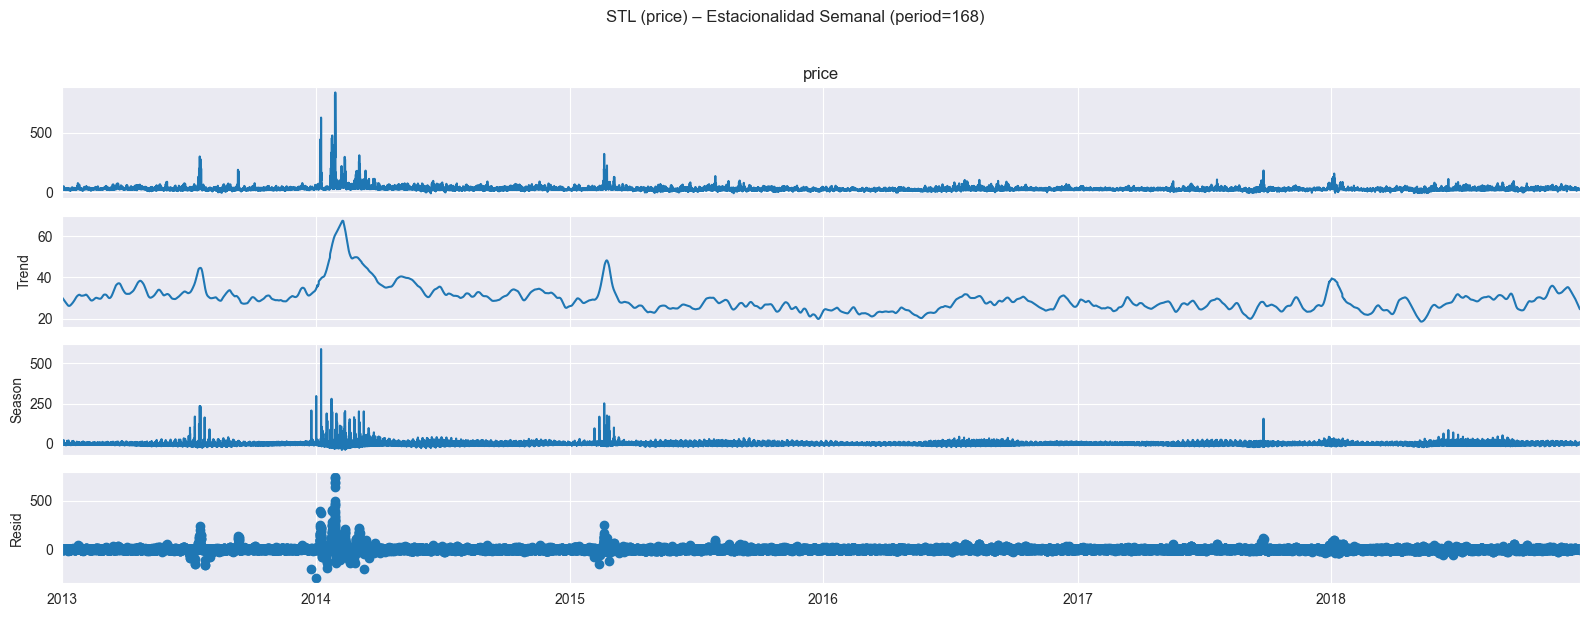

In [17]:
for period, label in [(24, "Diaria"), (24*7, "Semanal")]:
    stl_result = STL(df[target_variable].dropna(), period=period, robust=True).fit()
    fig = stl_result.plot()
    fig.suptitle(
        f"STL ({target_variable}) – Estacionalidad {label} (period={period})",
        y=1.02
    )
    plt.tight_layout()
    plt.show()

### Resumen de la Descomposición STL

**Tendencia**
- Con ventana diaria (24 h) la “tendencia” copia los picos crudos, así que no alisa nada.
- Con ventana semanal (168 h) la curva se suaviza y confirma que la serie es casi plana a largo plazo, con oscilaciones intermedias (ej. nivel algo más alto en 2014).

**Estacionalidad**
- Tanto en diario como en semanal, los picos extremos (sobre todo el de 2014) distorsionan por completo la señal estacional.
- Aunque existan ciclos diarios o semanales, el shock de esos eventos impide ver patrones claros con STL estándar.

**Residuos**
- Capturan casi todos los picos fuertes y no se parecen a ruido blanco: su varianza sube y baja con la volatilidad.
- Indican que esos eventos extremos son choques irregulares que ni la tendencia ni la estacionalidad explican.

**Conclusión**
- La serie no tiene tendencia sostenida, pero sí fluctuaciones a medio plazo.
- Los ciclos diarios/semanales están ocultos por la alta volatilidad y los picos.
- Esos picos dominan la componente residual, por lo que un modelo sin más información o técnicas especiales no los va a predecir bien.
- La serie no es estacionaria ni en media ni en varianza.


### 6. EDA: Estacionariedad y Autocorrelación

- *ADF Test*  
  - Estadístico ADF: adf_results["ADF Statistic"]  
  - p-value: adf_results["p-value"]  
  - Valores críticos:  
    - 1%: adf_results["crit_1%"]  
    - 5%: adf_results["crit_5%"]  
    - 10%: adf_results["crit_10%"]  
  > Si *p-value < 0.05*, rechazamos H₀ y la serie se considera estacionaria.

- *ACF y PACF* (lags = 168)  
  - *ACF*: observa la velocidad de decaimiento y picos en lags clave (e.g., 24, 168).  
  - *PACF*: identifica hasta qué rezago persiste la correlación (útil para órdenes AR).

In [18]:
# 6.1 Prueba de Dickey-Fuller Aumentada (ADF)
series = df[target_variable].dropna()
adf_stat, p_value, _, _, crit_vals, _ = adfuller(series)
adf_results = {
    "ADF Statistic": adf_stat,
    "p-value": p_value,
    **{f"crit_{level}": val for level, val in crit_vals.items()}
}

In [20]:
adf_results

{'ADF Statistic': np.float64(-20.33285658366907),
 'p-value': 0.0,
 'crit_1%': np.float64(-3.4304748972615964),
 'crit_5%': np.float64(-2.861595202079409),
 'crit_10%': np.float64(-2.5667993822316237)}

In [24]:
# 6.2 Gráficos de ACF y PACF (hasta 7 días de lags)
n_lags = 168
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle(f'ACF y PACF: {target_variable}', fontsize=16)

plot_acf(series, lags=n_lags, ax=axes[0])
axes[0].set_title('ACF')
axes[0].grid(True, linestyle='--', alpha=0.6)

plot_pacf(series, lags=n_lags, ax=axes[1], method='ols')
axes[1].set_title('PACF')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**1. Prueba ADF (Augmented Dickey–Fuller)**
- **Estadístico ADF**: –20.33
- **p-value**: 0.000
- **Valores críticos**:
  - 1%: –3.43
  - 5%: –2.86
  - 10%: –2.57

 Como el *p-value* es prácticamente cero (< 0.05) y el estadístico ADF es mucho menor que todos los valores críticos, **rechazamos la hipótesis nula** de raíz unitaria. Esto indica que la serie de precios es **estacionaria** en nivel, sin necesidad de diferenciación no estacional adicional.

---

**2. Funciones de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)**
- La **ACF** muestra una **decadencia lenta** en los primeros lags, señalando dependencia temporal fuerte, y picos claros en los rezagos **24** (diario) y sus múltiplos (48, 72, …) así como en **168** (semanal).
- La **PACF** presenta un **pico significativo en lag 1**, seguido de caídas abruptas (debido a la estacionariedad), y leves picos residuales en los rezagos estacionales (24, 168).


### 7. Diferenciación Estacional y Evaluación de Estacionariedad

1. *Diferenciación estacional*: aplicamos S=24 (horas) para remover patrones diarios.  
2. *ADF Test* sobre la serie diferenciada (seasonal_diff).
   - Si *p-value < 0.05*, rechazamos H₀ y la serie se considera estacionaria.  
3. *ACF/PACF* (lags=168) para identificar rezagos relevantes y posibles órdenes AR/SAR o MA/SMA.  
4. *Visualización* de la serie diferenciada para comprobar estabilidad (media cercana a 0 y varianza constante).

In [21]:
# 7.1 Diferenciación estacional (S = 24 horas)
S = 24
df['price_seasonal_diff'] = df[target_variable].diff(S)
seasonal_diff = df['price_seasonal_diff'].dropna()

In [22]:
# 7.2 ADF Test en la serie diferenciada
adf_stat_s, pval_s, _, _, crit_s, _ = adfuller(seasonal_diff)
adf_seasonal_results = {
    "ADF Statistic": adf_stat_s,
    "p-value": pval_s,
    **{f"crit_{level}": val for level, val in crit_s.items()}
}

In [23]:
adf_seasonal_results

{'ADF Statistic': np.float64(-38.14838678598181),
 'p-value': 0.0,
 'crit_1%': np.float64(-3.430474961702609),
 'crit_5%': np.float64(-2.8615952305604417),
 'crit_10%': np.float64(-2.566799397391235)}

In [25]:
# 7.3 ACF y PACF (lags = 168)
n_lags = 168
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle(f'ACF/PACF – Serie Diferenciada Estacionalmente (S={S})', fontsize=16)

plot_acf(seasonal_diff, lags=n_lags, ax=axes[0])
axes[0].set_title('ACF (seasonal diff)')
plot_pacf(seasonal_diff, lags=n_lags, ax=axes[1], method='ols')
axes[1].set_title('PACF (seasonal diff)')

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

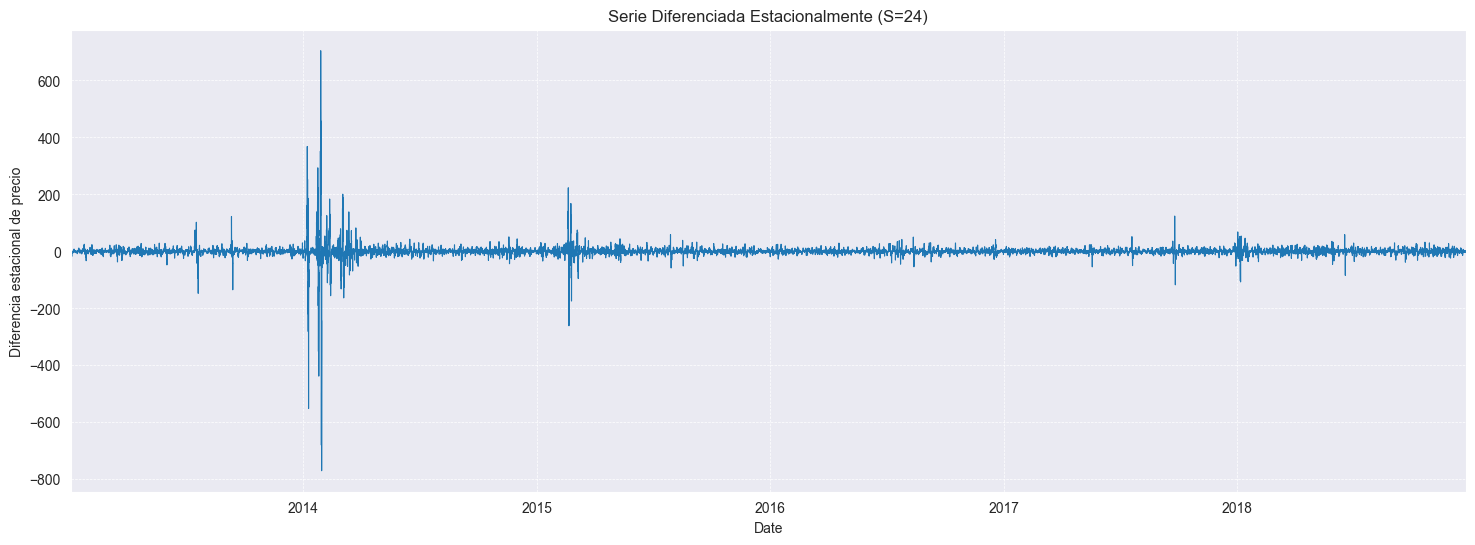

In [26]:
# 7.4 Serie diferenciada
plt.figure(figsize=(18, 6))
seasonal_diff.plot(title=f'Serie Diferenciada Estacionalmente (S={S})', linewidth=0.8)
plt.ylabel('Diferencia estacional de precio')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

**Resumen de Resultados de Diferenciación Estacional**

La diferenciación estacional (D=1, con un ciclo de 24) ha logrado que la serie de tiempo sea estacionaria, según la prueba ADF (p-value en ceros y estadístico ADF muy negativo).

En la gráfica, se observa que la serie ahora fluctúa alrededor de cero, sin la estructura periódica clara de la original. La volatilidad y los picos extremos persisten, lo cual es consistente con el efecto de la diferenciación en la media, no necesariamente en la varianza o los outliers.

El análisis de las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) tras la diferenciación estacional revela lo siguiente:

* La ACF muestra un decaimiento más rápido en los primeros lags, con un pico negativo significativo en el lag 24, sugiriendo un componente SMA(1) estacional.
* La PACF presenta un corte relativamente rápido en los lags no estacionales, con picos positivos significativos en los lags 1 y 2, indicando un posible componente AR(p) no estacional, posiblemente AR(2).
* La PACF también muestra un pico negativo significativo en el lag 24, lo que sugiere un componente SAR(1) estacional.

**Determinación de Órdenes Iniciales para el Modelo SARIMA:**

* La serie es estacionaria tras aplicar D=1, por lo que no se requiere diferenciación regular adicional (d=0).
* **Órdenes No Estacionales (p, d, q):** Se probará con **p=2**, **d=0**, y se comenzará con **q=0**.
* **Órdenes Estacionales (P, D, Q, S):** Se utilizarán **P=1**, **D=1**, **Q=1**, con una estacionalidad de **S=24**.

**Modelo SARIMA Inicial Propuesto:** SARIMA(2, 0, 0)x(1, 1, 1, 24)

**Siguiente paso:** Antes de ajustar este modelo SARIMA, se dividirá el conjunto de datos (`df`) en entrenamiento y prueba de forma cronológica, utilizando las últimas dos semanas de datos (14 días * 24 horas/día) para la prueba.

### 8. División de datos (Train/Test)

Separamos los últimos *14 días* (336 horas) como conjunto de prueba y el resto como entrenamiento.  
Luego visualizamos la variable objetivo en ambos conjuntos para verificar la división cronológica.  
Finalmente, preparamos:
- *X_train, y_train*  
- *X_test,  y_test*

In [46]:
# Definir número de horas de prueba
n_test_hours = 14 * 24

# División cronológica
train_df = df.iloc[:-n_test_hours]
test_df  = df.iloc[-n_test_hours:]

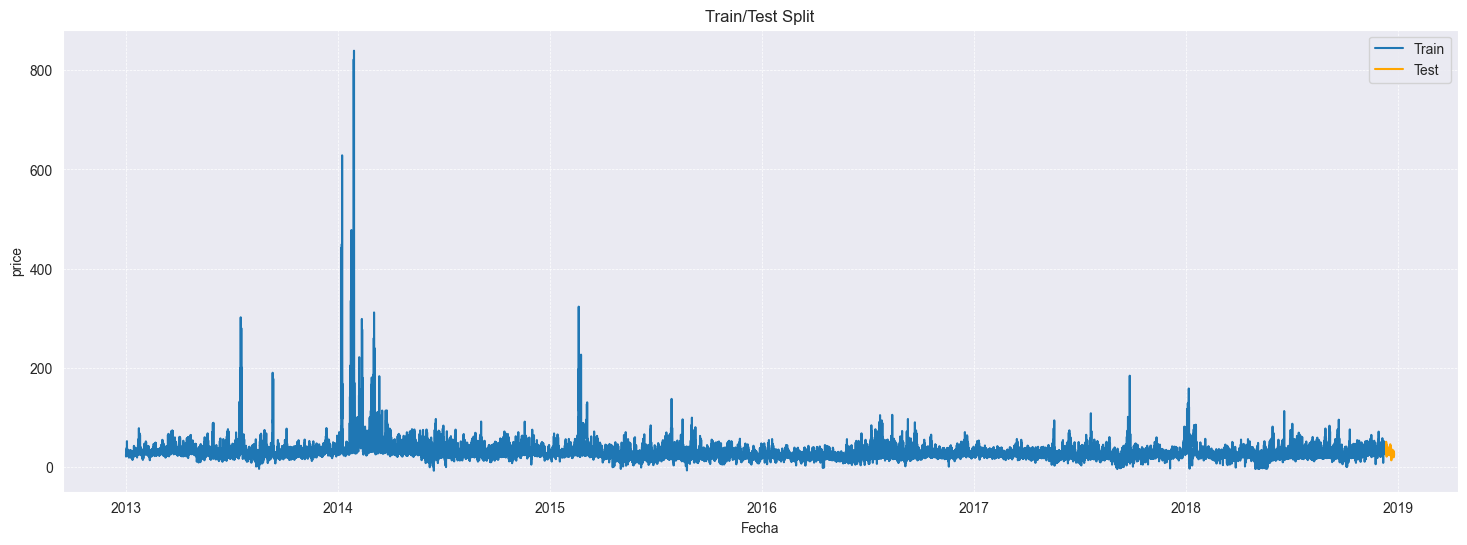

In [47]:
# Visualizar división en la serie objetivo
plt.figure(figsize=(18, 6))
plt.plot(train_df.index, train_df[target_variable], label='Train')
plt.plot(test_df.index,  test_df[target_variable],  label='Test', color='orange')
plt.title('Train/Test Split')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [54]:
X_train = train_df[feature_variables]
y_train = train_df[target_variable]
X_test  = test_df[feature_variables]
y_test  = test_df[target_variable]

Dividimos nuestros datos en los conjuntos de entrenamiento y prueba.

**Resumen del Ajuste del Modelo SARIMA Univariado**

A continuación, se procederá a implementar y ajustar el primer modelo SARIMA utilizando únicamente la variable `price` del conjunto de entrenamiento (`y_train`). Se emplearán los órdenes determinados previamente: (p=2, d=0, q=0) para la parte no estacional y (P=1, D=1, Q=1, S=24) para la parte estacional.

Es importante tener en cuenta que el ajuste de modelos SARIMA con esta cantidad de datos y un periodo estacional de 24 puede requerir un tiempo considerable de procesamiento.

### 9. SARIMA Univariado

Ajustamos un modelo SARIMA usando:
- *order* = (2, 0, 0)  
- *seasonal_order* = (1, 1, 1, 24)  

A continuación:
1. *Resumen* del modelo: coeficientes, AIC, pruebas estadísticas.  
2. *Diagnóstico de residuales*:  
   - Ruido blanco vs. patrones.  
   - Normalidad (Q-Q plot, Jarque-Bera).  
   - Autocorrelación (Ljung-Box).

In [55]:
# Parámetros del modelo (p, d, q) x (P, D, Q, S)
order = (2, 0, 0)
seasonal_order = (1, 1, 1, 24)

# Ajuste del modelo
model = SARIMAX(
    endog=y_train,
    order=order,
    seasonal_order=seasonal_order,
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_sarima = model.fit(disp=False)

                                      SARIMAX Results                                       
Dep. Variable:                                price   No. Observations:                52080
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 24)   Log Likelihood             -167408.699
Date:                              Wed, 14 May 2025   AIC                         334829.398
Time:                                      16:58:17   BIC                         334882.555
Sample:                                  01-01-2013   HQIC                        334846.018
                                       - 12-10-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.002      0.065      0.948      -0.004       0.005
ar.L1          1.01

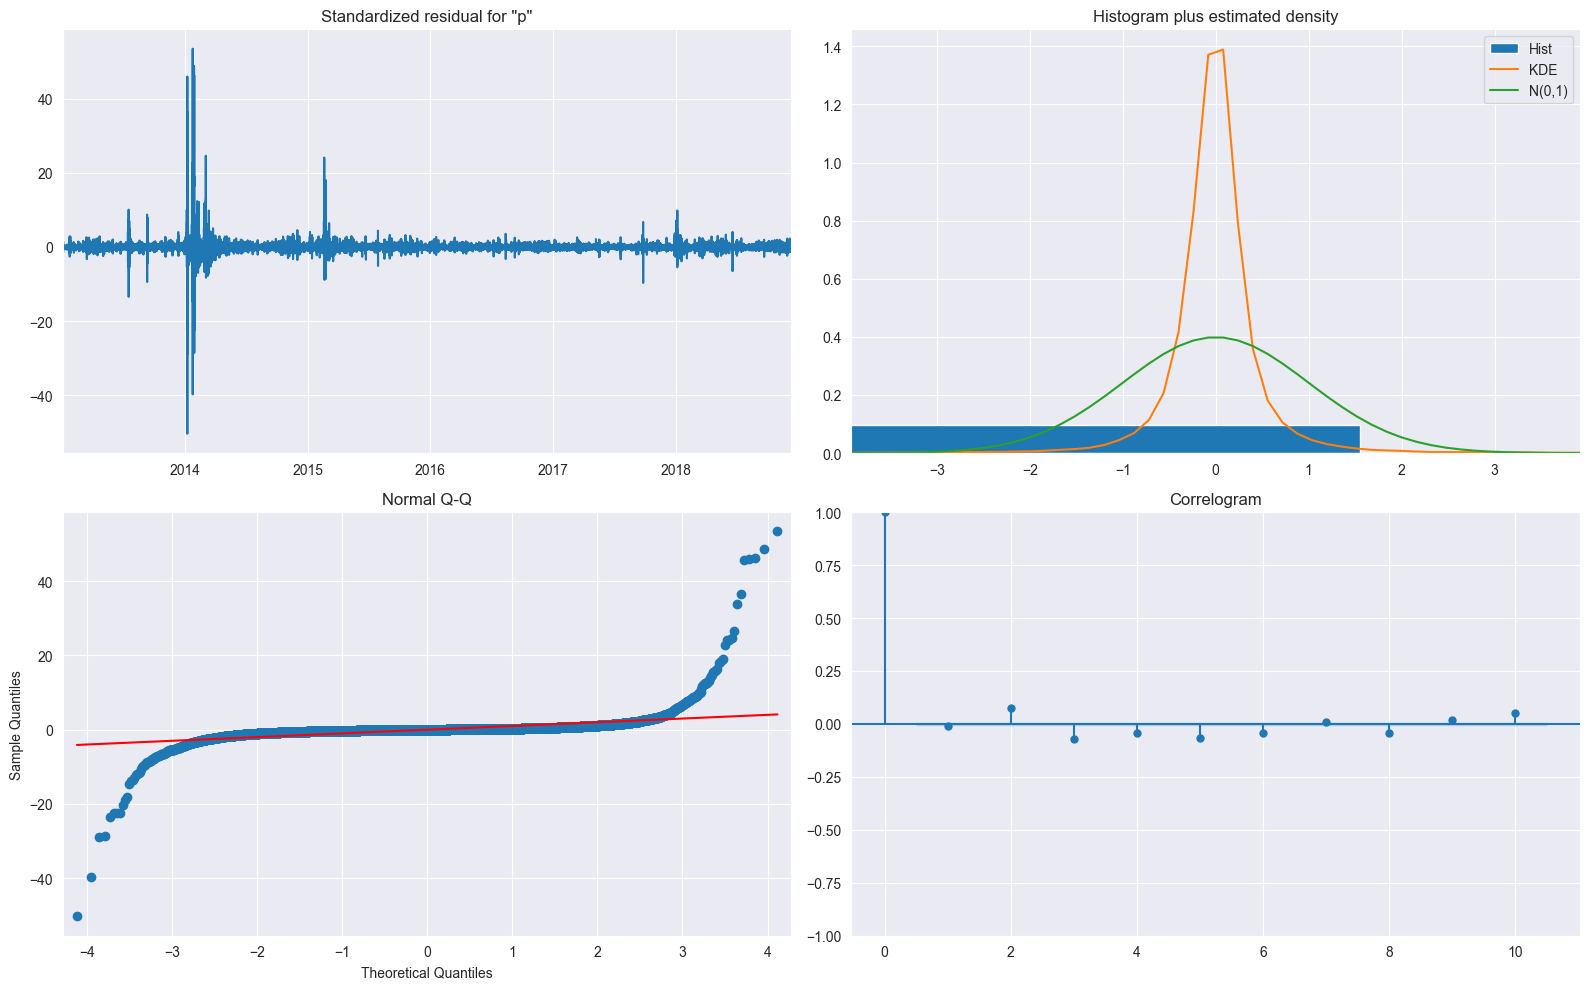

In [57]:
print(results_sarima.summary())
results_sarima.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

**Resumen del Análisis del Modelo SARIMA(2, 0, 0)x(1, 1, 1, 24) y Diagnósticos**

* El término `intercept` parece no ser importante estadísticamente (p-value alto), así que podríamos quitarlo después.
* Los términos AR(1), AR(2) no estacionales, SAR(1) y SMA(1) estacionales sí son importantes (p-values bajos). Esto valida nuestras elecciones iniciales de los órdenes del modelo.
* La varianza de los errores que no explica el modelo (`sigma2`) se estimó en 36.46.

Las pruebas de diagnóstico de los errores del modelo (residuales) nos dan una imagen mixta:

* La prueba de Ljung-Box sugiere que **no hay autocorrelación** en los errores (al menos para los primeros lags), lo cual es bueno. El modelo parece haber capturado la dependencia temporal.
* Sin embargo, la prueba de Jarque-Bera nos dice que los errores **no siguen una distribución normal**. Esto se ve también en lo chueca y picuda que es la distribución de los errores (Skewness y Kurtosis altísimas).
* También hay **heterocedasticidad**, o sea, la "dispersión" de los errores no es constante a lo largo del tiempo.

Al ver las gráficas de diagnóstico:

* La gráfica de los errores estandarizados confirma que la dispersión cambia con el tiempo (heterocedasticidad).
* El histograma muestra claramente que los errores no tienen forma de campana normal, sino que están muy concentrados al centro y tienen colas largas.
* El gráfico Q-Q también muestra que los puntos se alejan bastante de la línea recta que indicarían normalidad, especialmente en los extremos.
* La función de autocorrelación (ACF) de los errores no muestra picos significativos, lo que apoya la idea de que el modelo capturó bien la autocorrelación lineal.

**En conclusión:**

El modelo SARIMA parece haber hecho un buen trabajo al capturar la estructura lineal de nuestros datos, incluyendo la parte estacional. Sin embargo, los errores que no explica el modelo no son normales y su varianza no es constante. Esto probablemente se debe a los cambios bruscos de precio y a los valores atípicos que un modelo lineal como SARIMA no puede modelar completamente.

**Decisión:**

A pesar de estas limitaciones en los errores, usaremos este modelo como nuestra **referencia lineal base**. Los pronósticos que haga nos darán una idea, pero los rangos de incertidumbre (intervalos de confianza) que genere no serán muy confiables debido a los problemas con los errores.

Podríamos intentar quitar el intercepto que no fue significativo, pero para no complicarnos más por ahora, **mantendremos este modelo y pasaremos a hacer los pronósticos en los datos de prueba.**

### 10. Pronósticos SARIMA

- Creamos el forecast a partir del modelo ajustado para los mismos pasos que el conjunto de prueba.  
- Obtenemos la media del pronóstico (y_pred_sarima) y los intervalos de confianza al 95% (lower_ci, upper_ci).  
- Visualizamos:
  - *Train (contexto)*: últimas 2×n_steps del set de entrenamiento.  
  - *Actual*: valores reales del test.  
  - *Forecast*: predicción SARIMA (línea discontinua).  
  - *95% CI*: sombreado de intervalo de confianza.

In [58]:
# Generar forecast
n_steps = len(y_test)
forecast_obj = results_sarima.get_forecast(steps=n_steps)
y_pred_sarima = forecast_obj.predicted_mean
conf_int        = forecast_obj.conf_int(alpha=0.05)
lower_ci, upper_ci = conf_int.iloc[:, 0], conf_int.iloc[:, 1]

# Alinear índices
y_pred_sarima.index = y_test.index
lower_ci.index      = y_test.index
upper_ci.index      = y_test.index

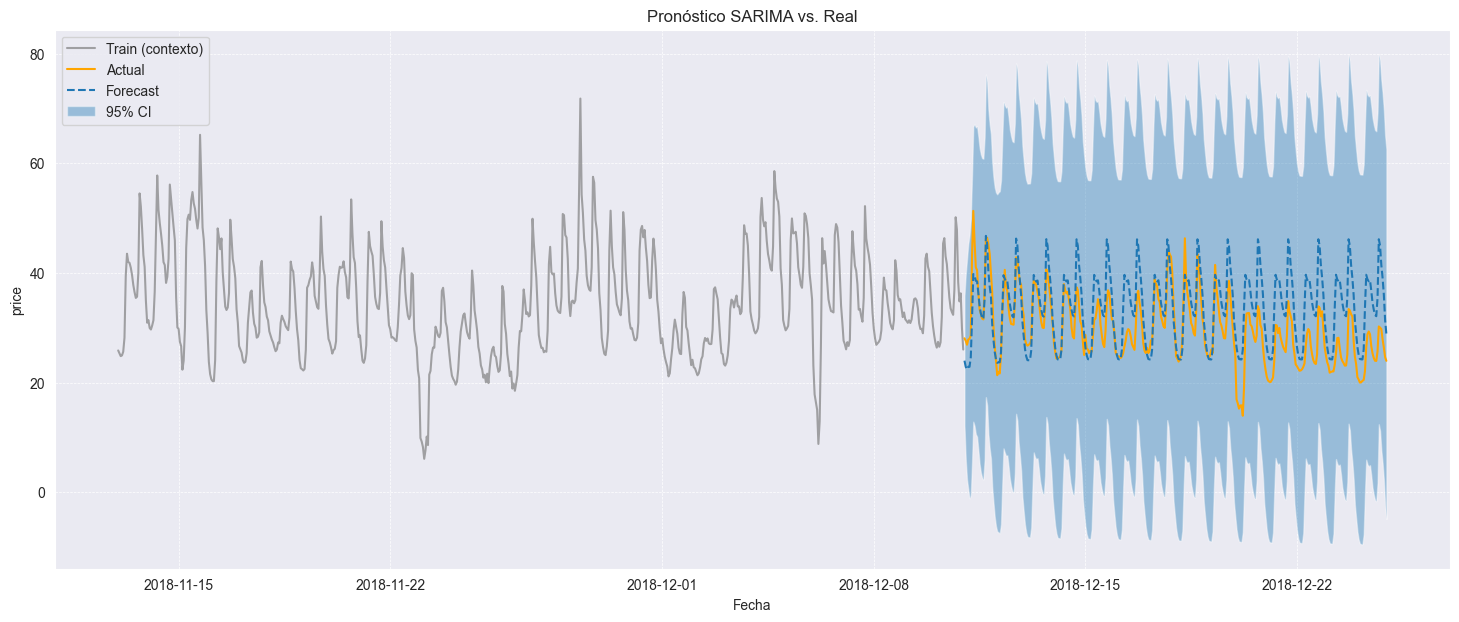

In [59]:
# Visualizar pronóstico vs. real
plt.figure(figsize=(18, 7))
plt.plot(
    train_df.index[-2*n_steps:], 
    y_train[-2*n_steps:], 
    label='Train (contexto)', 
    color='gray', alpha=0.7
)
plt.plot(y_test.index, y_test, label='Actual', color='orange', linewidth=1.5)
plt.plot(
    y_pred_sarima.index, 
    y_pred_sarima, 
    label='Forecast', 
    linestyle='--', linewidth=1.5
)
plt.fill_between(
    lower_ci.index, lower_ci, upper_ci,
    alpha=0.4, label='95% CI'
)
plt.title('Pronóstico SARIMA vs. Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

**Resumen de la Interpretación del Pronóstico SARIMA**

+ El modelo SARIMA muestra el patrón diario de precios bastante bien, con sus altas y bajas cada día. El nivel general del pronóstico sigue los precios reales, aunque a veces no acierta tan bien los puntos más altos y más bajos.

+ El modelo sigue la dirección general de los precios día a día, pero no predice perfecto los cambios de cada hora ni los picos más grandes. Los rangos de error que dibuja el modelo son muy amplios y uniformes, lo que no es muy realista porque el modelo asume que la "brincadera" de los precios es siempre la misma, y ya vimos que no es así.

+ Los primeros valores que predice el modelo parecen una continuación lógica de los precios que veníamos viendo.

+ **En pocas palabras:** El modelo SARIMA es una base para comparar. Entiende el ritmo diario y el nivel general de los precios. Lo que no le va tan bien es predecir qué tanto van a subir o bajar los precios en momentos puntuales, y por eso sus rangos de error no son muy confiables.

+ Creemos que modelos más avanzados, sobre todo si tienen en cuenta otros factores como la carga, podrían predecir mejor los precios.

**Siguiente Paso: Números para Ver Qué Tan Bien Predijo**

+ Ahora vamos a calcular algunos números (MAPE, MSE, RMSE, R²) para medir exactamente qué tan bueno fue este modelo SARIMA. Así tendremos una referencia para ver si los modelos futuros son mejores.

### 11. Evaluación del Modelo SARIMA (Baseline)

Calculamos las métricas de evaluación para el modelo SARIMA sobre el conjunto de prueba:

- *MAE*: Mean Absolute Error  
- *MSE*: Mean Squared Error  
- *RMSE*: Root Mean Squared Error  
- *MAPE (%)*: Mean Absolute Percentage Error  
- *R²*: Coeficiente de determinación  

Estas métricas servirán como baseline para comparar futuros modelos.

In [60]:
# 11.1 Calcular métricas
mae  = mean_absolute_error(y_test, y_pred_sarima)
mse  = mean_squared_error(y_test, y_pred_sarima)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred_sarima)

In [61]:
# MAPE evitando ceros en y_test
mask = y_test != 0
mape = (np.abs((y_test[mask] - y_pred_sarima[mask]) / y_test[mask]).mean() * 100) if mask.any() else np.nan

In [62]:
# 11.2 Guardar y mostrar métricas
sarima_metrics = {
    'Model': 'SARIMA_Univariate',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE (%)': mape,
    'R2': r2
}

In [64]:
for metric, value in sarima_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

Model: SARIMA_Univariate
MAE: 4.8986
MSE: 37.2472
RMSE: 6.1031
MAPE (%): 17.5655
R2: 0.0154


**Resumen de las Métricas del Modelo SARIMA (Baseline)**

Los números nos dicen lo siguiente sobre qué tan bien predijo el modelo SARIMA:

1.  **MAE (Error Absoluto Medio):** En promedio, nos equivocamos por unos 4.9 €/MWh en cada predicción.
2.  **RMSE (Error Cuadrático Medio):** Este error es un poco mayor (~6.1 €/MWh) porque le da más importancia a los errores grandes.
3.  **MAPE (Error Porcentual Absoluto Medio):** En promedio, nuestro error fue de alrededor del 17.6% del precio real. Para los precios de electricidad, que a veces cambian mucho, esto es un punto de partida, pero podemos mejorar.
4.  **R² (Qué tanto explica el modelo):** Este valor es **muy bajo** (0.0154, o sea, 1.5%). Esto significa que nuestro modelo SARIMA, usando solo el precio anterior, explica muy poco de por qué cambian los precios reales. Esto confirma lo que vimos en la gráfica: aunque sigue el ritmo diario, se pierde muchos de los altibajos reales.

**Conclusión General del Modelo SARIMA (Baseline):**

El modelo SARIMA entiende el patrón diario básico, pero en general no es muy bueno explicando por qué varían los precios (el R² es muy malo). Los números que obtuvimos (MAE, RMSE, MAPE) son nuestra primera medida de qué tan bien predijimos. Está claro que necesitamos modelos más sofisticados, que miren otras cosas además del precio pasado, y que puedan entender relaciones más complejas.

**Siguiente Paso: Redes Neuronales**

Ahora vamos a la parte interesante: usar redes neuronales. Empezaremos con un **Multilayer Perceptron (MLP)**.

**Lo que vamos a hacer:**

1.  Hacer un MLP que solo mire el precio pasado para predecir el futuro (univariado).
2.  Hacer un MLP que mire el precio pasado Y la carga para predecir el futuro (multivariado).

Para que las redes neuronales puedan aprender, necesitamos organizar nuestros datos de series de tiempo en "ventanas". Es importante escalar los datos después de separarlos en entrenamiento y prueba, y solo enseñarle cómo escalar al conjunto de entrenamiento para no hacer data leakage.

### 12. Preparación de datos para redes neuronales

- Definimos create_sequences para ventanas de 24 pasos y horizonte 1.  
- Escalamos con MinMaxScaler:  
  - *Univariado*: solo la serie de precios.  
  - *Multivariado*: precio + pronósticos de carga.  
- Generamos secuencias (X, y) y aplanamos X para entrada MLP.  
- Guardamos los scalers para revertir la normalización después del pronóstico.

In [65]:
def create_sequences(data, target, window_size, target_steps=1):
    X, y = [], []
    n = len(data)
    for i in range(n - window_size - target_steps + 1):
        X.append(data[i : i + window_size])
        y.append(target[i + window_size : i + window_size + target_steps])
    X = np.array(X)
    y = np.array(y)
    if target_steps == 1:
        y = y.reshape(-1, 1)
    return X, y

In [71]:
window_size = 24
target_steps = 1

In [72]:
# --- Univariado (solo precio) ---
train_uni = y_train.values.reshape(-1, 1)
test_uni  = y_test.values.reshape(-1, 1)

scaler_uni = MinMaxScaler()
scaled_uni_train = scaler_uni.fit_transform(train_uni)
scaled_uni_test  = scaler_uni.transform(test_uni)

X_uni_train, y_uni_train = create_sequences(
    scaled_uni_train,
    scaled_uni_train.flatten(),
    window_size,
    target_steps
)
X_uni_test, y_uni_test = create_sequences(
    scaled_uni_test,
    scaled_uni_test.flatten(),
    window_size,
    target_steps
)

In [73]:
# Aplanar X para MLP
X_uni_train_flat = X_uni_train.reshape(len(X_uni_train), -1)
X_uni_test_flat  = X_uni_test.reshape(len(X_uni_test),   -1)

In [102]:
X_uni_train_seq, y_uni_train_seq = create_sequences(scaled_uni_train, scaled_uni_train.flatten(), window_size, target_steps)
X_uni_test_seq, y_uni_test_seq = create_sequences(scaled_uni_test, scaled_uni_test.flatten(), window_size, target_steps)

In [77]:
# --- Multivariado (precio + exógenas) ---
multi_cols = ['price', 'system_load_forecast', 'zonal_load_forecast']

# Extraer los datos multivariados
train_multi = train_df[multi_cols].values
test_multi  = test_df[multi_cols].values

# Escalado
scaler_multi = MinMaxScaler()
scaled_multi_train = scaler_multi.fit_transform(train_multi)
scaled_multi_test  = scaler_multi.transform(test_multi)

# Crear secuencias y aplanar para MLP
X_multi_train_seq, y_multi_train_seq = create_sequences(
    scaled_multi_train,
    scaled_multi_train[:, 0],
    window_size, target_steps
)
X_multi_test_seq, y_multi_test_seq = create_sequences(
    scaled_multi_test,
    scaled_multi_test[:, 0],
    window_size, target_steps
)

X_multi_train_flat = X_multi_train_seq.reshape(len(X_multi_train_seq), -1)
X_multi_test_flat  = X_multi_test_seq.reshape(len(X_multi_test_seq),   -1)

### 12. Preparación de datos para redes neuronales

En este paso se prepararon los datos para poder entrenar diferentes modelos de redes neuronales. Los pasos principales fueron:

1. Se creó una función `create_sequences()` para generar ventanas temporales de 24 horas, que servirán como entrada a las redes neuronales.

2. Se realizó el escalado de datos usando MinMaxScaler:
   - Univariado: Se normalizó solo la serie de precios
   - Multivariado: Se normalizaron el precio y los pronósticos de carga

3. Se generaron las secuencias de entrenamiento y prueba:
   - X_uni_train/test: Ventanas para el modelo univariado
   - X_multi_train/test: Ventanas para el modelo multivariado
   - y_uni_train/test: Valores objetivo univariado
   - y_multi_train/test: Valores objetivo multivariado

4. Se aplanaron las matrices para poder usar modelos MLP:
   - X_uni_train/test_flat: Datos univariados aplanados
   - X_multi_train/test_flat: Datos multivariados aplanados

5. Se guardaron los escaladores (MinMaxScaler) para poder revertir la normalización al hacer predicciones.

Esto permitió tener los datos en el formato adecuado para entrenar diferentes arquitecturas de redes neuronales como MLP, CNN y LSTM.


### 13. MLP Univariado

- *Arquitectura*  
  - Capas ocultas: 100 → 50 neuronas (ReLU)  
  - Capa de salida: 1 neurona (regresión)  

- *Entrenamiento*  
  - Optimizer: Adam (lr=0.001); Loss: MSE  
  - Callbacks:  
    - EarlyStopping (patience=100, restaura mejor peso)  
    - ModelCheckpoint (guarda mejor modelo)  
    - ReduceLROnPlateau (factor 0.2, patience=7)  
  - Épocas: 50; batch_size: 64; validación interna: 20%

- *Resultado*  
  - Gráfica de entrenamiento vs. validación (MSE Loss) para monitorizar ajuste y posibles overfitting.

In [78]:
from tensorflow.keras.optimizers import Adam
# Definir modelo
input_dim = X_uni_train_flat.shape[1]
mlp_uni = Sequential(name="MLP_Univariate")
mlp_uni.add(Dense(100, activation='relu', input_shape=(input_dim,)))
mlp_uni.add(Dense(50, activation='relu'))
mlp_uni.add(Dense(1))  # salida unitaria

# Compilar
mlp_uni.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [79]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    ModelCheckpoint("best_mlp_univariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [82]:
# Entrenamiento
history_uni = mlp_uni.fit(
    X_uni_train_flat, y_uni_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 7.0360e-05 - val_loss: 1.9530e-05 - learning_rate: 2.0000e-04
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 6.8507e-05 - val_loss: 1.9546e-05 - learning_rate: 2.0000e-04
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 6.7120e-05 - val_loss: 1.9273e-05 - learning_rate: 2.0000e-04
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 6.6532e-05 - val_loss: 1.9366e-05 - learning_rate: 2.0000e-04
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 6.5589e-05 - val_loss: 1.9516e-05 - learning_rate: 2.0000e-04
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 6.4238e-05 - val_loss: 1.9585e-05 - learning_rate: 2.0000e-04
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 6.3583e-05 - val_loss: 1.9512e-05 - learning_rate: 2.0000e-04
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 6.2837e-05 - val_loss: 1.9391e-05 - learning_rate: 2.0000e-04
Epoch 9/

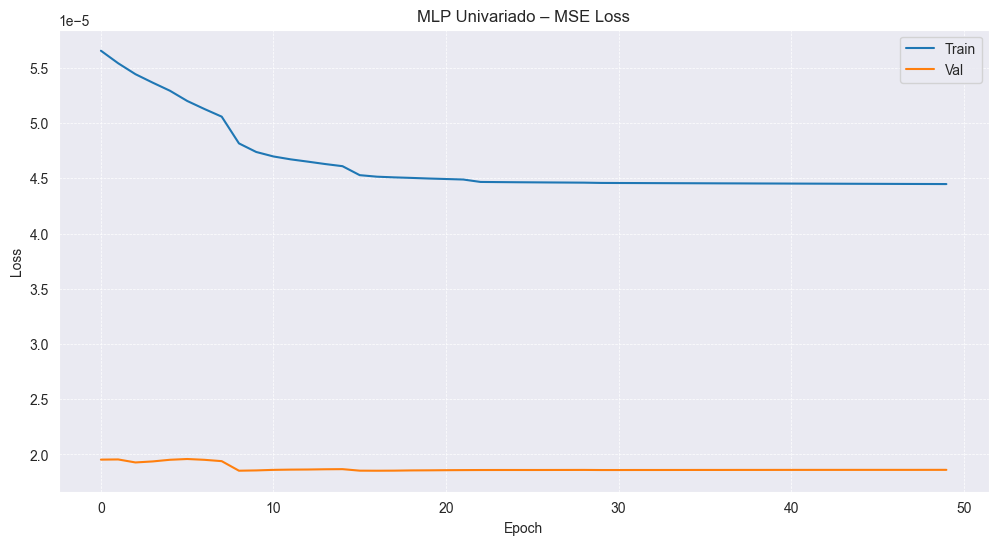

In [83]:
# Historial de pérdida
plt.figure(figsize=(12, 6))
plt.plot(history_uni.history['loss'], label='Train')
plt.plot(history_uni.history['val_loss'], label='Val')
plt.title('MLP Univariado – MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

+ Vemos que a partir de la época 20 el modelo converge, lo que sugiere que aprendió patrones de los datos univariados escalados.

+ La ausencia de overfitting severo (divergencia de `val_loss`) es positiva. El hecho de que `val_loss` sea menor que `loss` podría deberse a factores como la regularización implícita del `validation_split` o simplemente a la dinámica específica de este dataset y split, pero no es una señal de alarma grave mientras se mantenga estable.

**: Evaluación del MLP Univariado y Comparación**

Ahora evaluaremos el rendimiento de este MLP entrenado en el conjunto de prueba. Haremos predicciones, **invertiremos la escala** usando `scaler_univariate` (guardado previamente) para obtener los precios reales, y calcularemos las mismas métricas que para el SARIMA para poder comparar.

### 14. Evaluación del MLP Univariado

- Desescalamos las predicciones y ajustamos y_true eliminando las primeras 24 muestras (ventanas).  
- Calculamos:
  - *MAE, **MSE, **RMSE, **MAPE (%), **R²*  
- *Comparación* rápida con el baseline SARIMA.  
- *Gráfico*: predicciones MLP vs. valores reales del test set.

In [84]:
scaler_uni = joblib.load('scaler_univariate.joblib')
y_pred_scaled = mlp_uni.predict(X_uni_test_flat)
y_pred = scaler_uni.inverse_transform(y_pred_scaled).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [85]:
# Ajustar y_true al tamaño de las predicciones (eliminar ventanas iniciales)
y_true = y_test.values.flatten()[window_size:]

In [86]:
# Métricas
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

mlp_uni_metrics = {
    'Model': 'MLP_Univariate_v1',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE (%)': mape,
    'R2': r2
}

In [87]:
# Mostrar métricas
for metric, value in mlp_uni_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

# Comparación rápida con baseline SARIMA
print("\nBaseline SARIMA:")
for m in ['MAE','RMSE','MAPE (%)','R2']:
    print(f"{m}: {sarima_metrics[m]:.4f}" if isinstance(sarima_metrics[m], float) else f"{m}: {sarima_metrics[m]}")

Model: MLP_Univariate_v1
MAE: 1.4849
MSE: 4.0957
RMSE: 2.0238
MAPE (%): 5.1127
R2: 0.8751

Baseline SARIMA:
MAE: 4.8986
RMSE: 6.1031
MAPE (%): 17.5655
R2: 0.0154


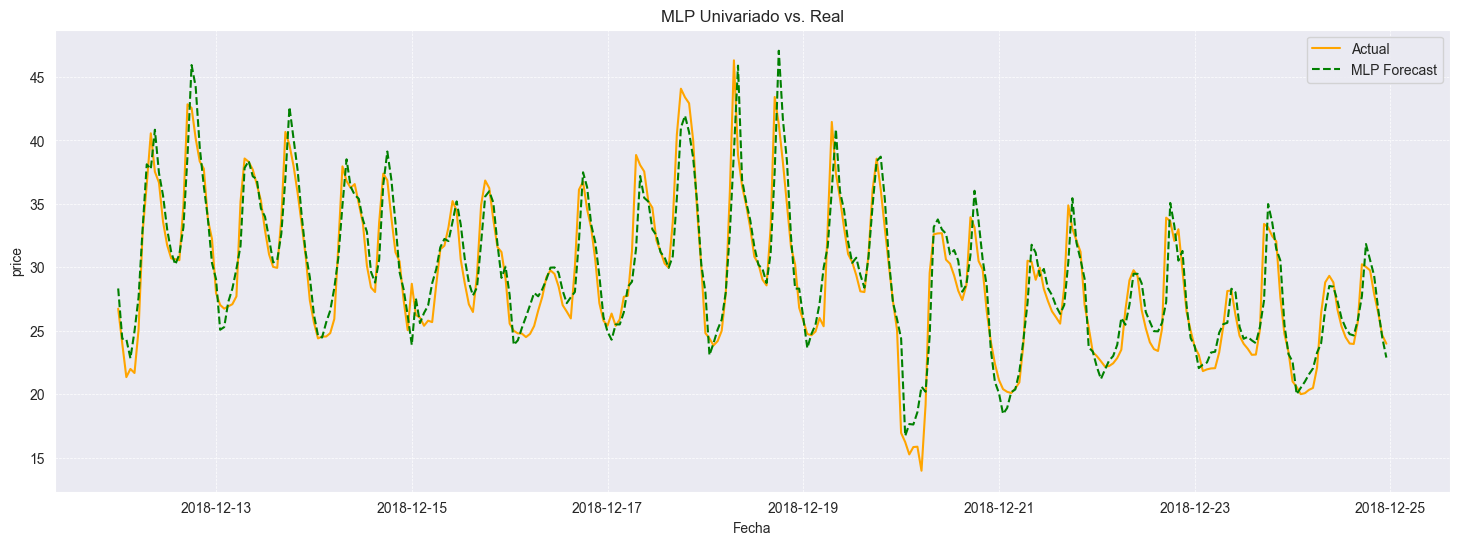

In [88]:
# Gráfico: pronóstico vs real
test_idx = y_test.index[window_size:]
plt.figure(figsize=(18,6))
plt.plot(test_idx, y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(test_idx, y_pred, label='MLP Forecast', color='green', linestyle='--', linewidth=1.5)
plt.title('MLP Univariado vs. Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

Recordando la evaluación del modelo SARIMA univariado como inicio. Sus métricas fueron: MAE ~4.9, RMSE ~6.1, MAPE ~17.6%, y un R² muy bajo de 0.0154, mostrando que explicaba muy poca variación real de los precios. Aunque captaba la estacionalidad diaria, no manejaba bien otras fluctuaciones. SARIMA nos dio una línea base cuantitativa.

Ahora, evaluamos el primer modelo neuronal, el MLP univariado (v1), y muestra una mejora importante.

Las métricas para este MLP univariado son:
- MAE: 1.4849 (bastante menor que los ~4.9 de SARIMA)
- RMSE: 2.0238 (mejor que los ~6.1 de SARIMA)
- MAPE (%): 5.1127 (una reducción significativa desde el ~17.6% de SARIMA)
- R²: 0.8751 (un salto enorme desde 0.0154; este modelo explica casi el 87.5% de la variabilidad en los precios de prueba)

Comparando, este MLP univariado supera ampliamente al SARIMA en todas las métricas. Demuestra que las redes neuronales pueden capturar patrones en la serie de tiempo que un modelo lineal como SARIMA no logró. El R² de ~0.875 indica que el ajuste predictivo es bastante bueno usando solo precios pasados. Visualmente, el pronóstico del MLP sigue mucho mejor los datos reales, capturando mejor picos y valles.

El siguiente paso lógico y del proyecto es implementar el MLP multivariado. Este usará precios pasados más variables exógenas como la carga para intentar mejorar la predicción. Ya tenemos los datos preparados para esto, con las ventanas y el escalado hecho correctamente (escalando después de dividir train/test y ajustando solo en entrenamiento para evitar filtraciones de datos). La arquitectura del MLP se adaptará para aceptar más características de entrada (24 pasos por 3 variables).

### 15. MLP Multivariado

- *Arquitectura*  
  - Capas ocultas: 128 → 64 neuronas (ReLU)  
  - Dropout: 20%  
  - Capa de salida: 1 neurona (regresión)  

- *Entrenamiento*  
  - Optimizer: Adam (lr=0.001); Loss: MSE  
  - Callbacks:  
    - EarlyStopping (patience=100)  
    - ModelCheckpoint (guarda mejor modelo)  
    - ReduceLROnPlateau (factor 0.2, patience=7)  
  - Épocas: 400; batch_size: 64; validación interna: 20%  

- *Resultado*  
  - Gráfica de entrenamiento vs. validación (MSE Loss)

In [89]:
# Definir modelo
input_dim = X_multi_train_flat.shape[1]
mlp_multi = Sequential(name="MLP_Multivariate")
mlp_multi.add(Dense(128, activation='relu', input_shape=(input_dim,)))
mlp_multi.add(Dense(64, activation='relu'))
mlp_multi.add(Dropout(0.2))
mlp_multi.add(Dense(1))  # salida unitaria

# Compilar
mlp_multi.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [91]:
callbacks_multi = [
    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    ModelCheckpoint("best_mlp_multivariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [92]:
history_multi = mlp_multi.fit(
    X_multi_train_flat, y_multi_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks_multi,
    verbose=1
)

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - loss: 0.0034 - val_loss: 6.2318e-05 - learning_rate: 0.0010
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 2.2176e-04 - val_loss: 5.1170e-05 - learning_rate: 0.0010
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1.8389e-04 - val_loss: 6.4632e-05 - learning_rate: 0.0010
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 1.5831e-04 - val_loss: 7.9394e-05 - learning_rate: 0.0010
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - loss: 1.2383e-04 - val_loss: 4.5709e-05 - learning_rate: 0.0010
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 1.7414e-04 - val_loss: 4.5696e-05 - learning_rate: 0.0010
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 1.6475e-04 - val_loss: 5.9987e-05 - learning_rate: 0.0010
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7621e-04 - val_loss: 2.9947e-05 - learning_rate: 0.0010
Epoch 9/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 724

In [93]:
# Historial de pérdida
plt.figure(figsize=(12, 6))
plt.plot(history_multi.history['loss'], label='Train')
plt.plot(history_multi.history['val_loss'], label='Val')
plt.title('MLP Multivariado – MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

El modelo multivariado aprendió muy rápido, encontrando el mejor rendimiento de validación en las primeras épocas.

Ahora, evaluaremos este MLP multivariado  en el conjunto de prueba. Haremos predicciones, invertiremos la escala usando `scaler_multivariate`, calcularemos las métricas y compararemos con el MLP univariado y el SARIMA.

### 16. Evaluación del MLP Multivariado

1. *Desescalado*: Usamos el scaler_univariate para revertir la normalización de las predicciones.  
2. *Alineación*: Ajustamos y_true eliminando las primeras 24 muestras (ventanas).  
3. *Métricas*: Calculamos MAE, MSE, RMSE, MAPE (%) y R², y las almacenamos en mlp_multi_metrics.  
4. *Comparación*: Contrastamos las métricas de:
   - SARIMA (baseline)  
   - MLP Univariado  
   - MLP Multivariado  
5. *Visualización*: Graficamos las predicciones vs. los valores reales del conjunto de prueba.

In [94]:
# 16.1 Desescalar predicciones
scaler_uni = joblib.load('scaler_univariate.joblib')
y_pred_scaled = mlp_multi.predict(X_multi_test_flat)
y_pred = scaler_uni.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [95]:
# 16.2 Ajustar y_true (eliminar las primeras ventanas)
y_true = y_test.values.flatten()[window_size:]

In [96]:
# 16.3 Calcular métricas
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

mlp_multi_metrics = {
    'Model':       'MLP_Multivariate_v1',
    'MAE':         mae,
    'MSE':         mse,
    'RMSE':        rmse,
    'MAPE (%)':    mape,
    'R2':          r2
}

In [97]:
# Mostrar métricas
for metric, value in mlp_multi_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

Model: MLP_Multivariate_v1
MAE: 1.8358
MSE: 5.4320
RMSE: 2.3307
MAPE (%): 6.6804
R2: 0.8344


In [98]:
# 16.4 Comparación con Baseline y MLP Univariado
print("\nComparación de métricas:")
comparison = {
    'SARIMA':    sarima_metrics,
    'MLP_Uni':   mlp_uni_metrics,
    'MLP_Multi': mlp_multi_metrics
}
print("Model      |   MAE   |  RMSE   | MAPE (%) |   R2")
for name, mets in comparison.items():
    print(f"{name:<10}| {mets['MAE']:.4f} | {mets['RMSE']:.4f} | {mets['MAPE (%)']:.2f}    | {mets['R2']:.4f}")


Comparación de métricas:
Model      |   MAE   |  RMSE   | MAPE (%) |   R2
SARIMA    | 4.8986 | 6.1031 | 17.57    | 0.0154
MLP_Uni   | 1.4849 | 2.0238 | 5.11    | 0.8751
MLP_Multi | 1.8358 | 2.3307 | 6.68    | 0.8344


In [99]:
test_idx = y_test.index[window_size:]
plt.figure(figsize=(18, 6))
plt.plot(test_idx, y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(test_idx, y_pred, label='MLP Multi Forecast', color='purple', linestyle='--', linewidth=1.5)
plt.title('MLP Multivariado vs Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

Ahora revisamos el MLP multivariado (v1). Sus métricas son:
- MAE: 1.8358
- RMSE: 2.3307
- MAPE (%): 6.6804
- R²: 0.8344

Comparando con los modelos anteriores:
- Es mejor que SARIMA en todas las métricas (errores más bajos, R² mucho mayor).
- Sin embargo, es ligeramente peor que el MLP univariado (errores un poco más altos, R² un poco menor).

Aunque el modelo multivariado es mejor que el baseline SARIMA, la adición de las variables exógenas en esta arquitectura MLP específica (con los datos aplanados) no logró superar el rendimiento del MLP usando solo la serie de precios. Esto sugiere que quizás esta manera de procesar las múltiples series de tiempo no capturó bien su interacción o la información temporal relevante.

Dado que esta implementación del MLP multivariado no superó al univariado, vamos a pasar a otros modelos neuronales más adecuados para secuencias.

El siguiente paso en el proyecto es trabajar con redes neuronales convolucionales (CNN), que son buenas manejando patrones en secuencias. Empezaremos implementando una CNN 1D para el caso univariado, usando los datos que ya preparamos en formato secuencial (no aplanado).

### 17. CNN 1D Univariada

- *Arquitectura*  
  - Entrada: ventana de 24 pasos × 1 feature  
  - Conv1D (64 filtros, kernel=3, padding causal) → MaxPool (2)  
  - Conv1D (32 filtros, kernel=3, padding causal) → MaxPool (2)  
  - Flatten → Dense (50, ReLU) → Dropout (20%) → Salida (1)  

- *Entrenamiento*  
  - Optimizer: Adam (lr=0.001); Loss: MSE  
  - Callbacks:
    - ModelCheckpoint (guarda mejor modelo)  
    - ReduceLROnPlateau (factor=0.2, patience=7)  
  - Épocas: 400; batch_size: 64; validación interna: 20%  

- *Resultado*  
  - Visualizamos la pérdida de entrenamiento vs. validación para monitorizar ajuste y detectar overfitting.

In [100]:
# Definir y compilar modelo
input_shape = (window_size, 1)
cnn_uni = Sequential(name="CNN_Univariate")
cnn_uni.add(Input(shape=input_shape))
cnn_uni.add(Conv1D(64, 3, activation='relu', padding='causal'))
cnn_uni.add(MaxPooling1D(2))
cnn_uni.add(Conv1D(32, 3, activation='relu', padding='causal'))
cnn_uni.add(MaxPooling1D(2))
cnn_uni.add(Flatten())
cnn_uni.add(Dense(50, activation='relu'))
cnn_uni.add(Dropout(0.2))
cnn_uni.add(Dense(1))
cnn_uni.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [101]:
# Callbacks
callbacks = [
    ModelCheckpoint("best_cnn_univariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [103]:
# Entrenamiento
y_cnn_uni_train=y_uni_train_seq
history_cnn = cnn_uni.fit(
    X_uni_train_seq,y_cnn_uni_train ,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5010e-04 - val_loss: 5.3386e-05 - learning_rate: 0.0010
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4616e-04 - val_loss: 4.2875e-05 - learning_rate: 0.0010
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9559e-04 - val_loss: 4.5466e-05 - learning_rate: 0.0010
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6761e-04 - val_loss: 4.3811e-05 - learning_rate: 0.0010
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4888e-04 - val_loss: 4.0498e-05 - learning_rate: 0.0010
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4413e-04 - val_loss: 3.8292e-05 - learning_rate: 0.0010
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2716e-04 - val_loss: 4.7397e-05 - learning_rate: 0.0010
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2293e-04 - val_loss: 4.5994e-05 - learning_rate: 0.0010
Epoch 9/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [104]:
# Historial de pérdida
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Val')
plt.title('CNN 1D Univariada – MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

Revisando el gráfico de pérdida de entrenamiento de la CNN 1D univariada.

+ Se ve que la pérdida de validación (`val_loss`, línea naranja) baja muy rápido, llegando a un valor bajo casi desde la época 10 y se mantiene casi plana después. La pérdida de entrenamiento (`train_loss`, línea azul) también cae rápido al inicio y luego se estabiliza en un nivel un poco más alto que la de validación.

+ Comparando, la pérdida mínima de validación de esta CNN es similar a la que se obtuvo con el MLP univariado.

+ Que ambos modelos neuronales univariados aprendan y lleguen a un buen rendimiento de validación tan rápido sugiere que los patrones principales en la serie de tiempo univariada (como el ciclo diario) son relativamente fáciles de capturar para estas arquitecturas una vez que los datos están escalados correctamente.

### 18. Evaluación CNN 1D Univariada

1. *Desescalado*: revirtiendo la normalización con el scaler univariado.  
2. *Alineación*: ajustamos y_true eliminando las primeras 24 muestras (ventanas).  
3. *Métricas*: MAE, MSE, RMSE, MAPE (%) y R², almacenadas en cnn_uni_metrics.  
4. *Comparación*: resumimos las métricas de SARIMA, MLP univariado y CNN univariada en una tabla.  
5. *Visualización*: graficamos los valores reales vs. la predicción CNN en el test set.

In [105]:
# Desescalar predicciones
scaler_uni = joblib.load('scaler_univariate.joblib')
y_pred_scaled = cnn_uni.predict(X_uni_test_seq)
y_pred = scaler_uni.inverse_transform(y_pred_scaled).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [106]:
# Alinear y_true eliminando ventanas iniciales
y_true = y_test.values.flatten()[window_size:]

In [107]:
# Calcular métricas
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

cnn_uni_metrics = {
    'Model':       'CNN_Univariate_v1',
    'MAE':         mae,
    'RMSE':        rmse,
    'MAPE (%)':    mape,
    'R2':          r2
}

In [108]:
# Mostrar métricas
for metric, value in cnn_uni_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

Model: CNN_Univariate_v1
MAE: 2.0020
RMSE: 2.6469
MAPE (%): 7.0828
R2: 0.7864


In [109]:
# Comparación con modelos anteriores
comparison = {
    'SARIMA':    sarima_metrics,
    'MLP_Uni':   mlp_uni_metrics,
    'CNN_Uni':   cnn_uni_metrics
}
print("\nModel     |   MAE   |  RMSE   | MAPE (%) |   R2")
for name, mets in comparison.items():
    print(f"{name:<9}| {mets['MAE']:.4f} | {mets['RMSE']:.4f} | {mets['MAPE (%)']:.2f}    | {mets['R2']:.4f}")


Model     |   MAE   |  RMSE   | MAPE (%) |   R2
SARIMA   | 4.8986 | 6.1031 | 17.57    | 0.0154
MLP_Uni  | 1.4849 | 2.0238 | 5.11    | 0.8751
CNN_Uni  | 2.0020 | 2.6469 | 7.08    | 0.7864


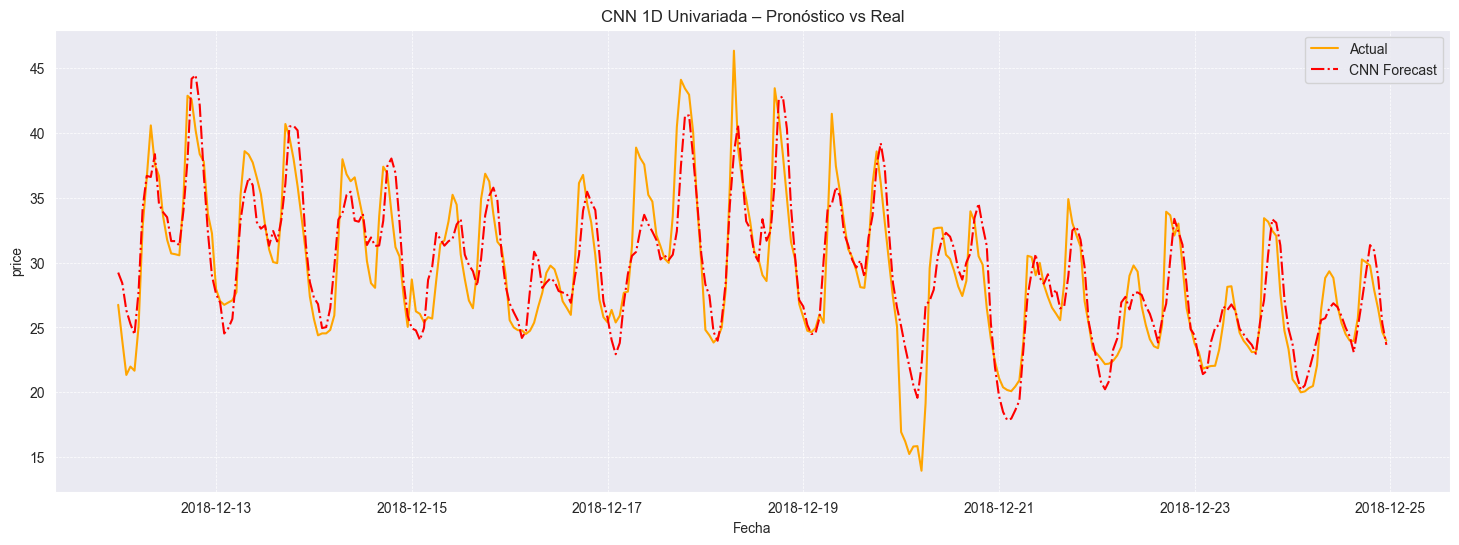

In [110]:
# Gráfico: pronóstico vs real
test_idx = y_test.index[window_size:]
plt.figure(figsize=(18, 6))
plt.plot(test_idx, y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(test_idx, y_pred, label='CNN Forecast', color='red', linestyle='-.', linewidth=1.5)
plt.title('CNN 1D Univariada – Pronóstico vs Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

Evaluamos ahora la CNN 1D univariada (v1) y comparamos sus resultados.

Sus métricas son:
- MAE: 2.0020
- RMSE: 2.6469
- MAPE (%): 7.0828
- R²: 0.7864

Comparando con los modelos previos:
- Es claramente mejor que el SARIMA baseline (MAE 4.8986, RMSE 6.1031, MAPE 17.57%, R² 0.0154). La CNN explica ~78.6% de la varianza frente al ~1.5% de SARIMA.
- Sin embargo, es peor que el MLP univariado (MAE 1.4849, RMSE 2.0238, MAPE 5.11%, R² 0.8751). El MLP univariado tuvo errores menores y explicó más varianza (~87.5%).

Visualmente, el pronóstico de la CNN sigue el patrón general, pero parece tener un ligero retraso o ser un poco más "suave" en picos y valles comparado con los datos reales y el MLP univariado.

La conclusión es que la CNN 1D univariada sí aprende bien y supera al baseline SARIMA, pero en esta primera versión y configuración, el MLP univariado dio mejores métricas. Podría ser que para esta serie particular, el MLP manejó mejor los patrones, o que la CNN necesite un ajuste más fino en sus hiperparámetros.

El siguiente paso es implementar la CNN 1D en su versión multivariada. Usaremos los datos secuenciales con las variables de carga adicionales. La idea es ver si la información extra ayuda a la CNN a mejorar su rendimiento, buscando igualar o superar al MLP univariado.

### 19. CNN 1D Multivariada

- *Arquitectura*  
  - Entrada: ventana (24 pasos × 3 features)  
  - Conv1D(64, kernel=3, padding causal) → MaxPool(2)  
  - Conv1D(32, kernel=3, padding causal) → MaxPool(2)  
  - Flatten → Dense(50, ReLU) → Dropout(20%) → Salida (1)  

- *Entrenamiento*  
  - Optimizador: Adam (lr=0.001)  
  - Función de pérdida: MSE  
  - Callbacks:
    - ModelCheckpoint (guarda mejor modelo)  
    - ReduceLROnPlateau (factor=0.2, patience=7)  
  - Épocas: 400; batch_size: 64; validación interna: 20%  

- *Resultado*  
  - Gráfica de pérdida de entrenamiento vs. validación para detectar over/underfitting.

In [111]:
# Definir la arquitectura
input_shape = (window_size, X_multi_train_seq.shape[2])  # (24, 3)
cnn_multi = Sequential(name="CNN_Multivariate")
cnn_multi.add(Input(shape=input_shape))
cnn_multi.add(Conv1D(64, 3, activation='relu', padding='causal'))
cnn_multi.add(MaxPooling1D(2))
cnn_multi.add(Conv1D(32, 3, activation='relu', padding='causal'))
cnn_multi.add(MaxPooling1D(2))
cnn_multi.add(Flatten())
cnn_multi.add(Dense(50, activation='relu'))
cnn_multi.add(Dropout(0.2))
cnn_multi.add(Dense(1))
cnn_multi.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [112]:
# Callbacks
callbacks = [
    ModelCheckpoint("best_cnn_multivariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [114]:
# Entrenamiento
y_cnn_multi_train = y_multi_train_seq
history_cnn_multi = cnn_multi.fit(
    X_multi_train_seq, y_cnn_multi_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 6.0910e-05 - learning_rate: 0.0010
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6534e-04 - val_loss: 6.4400e-05 - learning_rate: 0.0010
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3874e-04 - val_loss: 5.8763e-05 - learning_rate: 0.0010
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7594e-04 - val_loss: 4.5428e-05 - learning_rate: 0.0010
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.5884e-04 - val_loss: 4.2020e-05 - learning_rate: 0.0010
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4269e-04 - val_loss: 3.7671e-05 - learning_rate: 0.0010
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5339e-04 - val_loss: 4.2385e-05 - learning_rate: 0.0010
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3906e-04 - val_loss: 3.5495e-05 - learning_rate: 0.0010
Epoch 9/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 

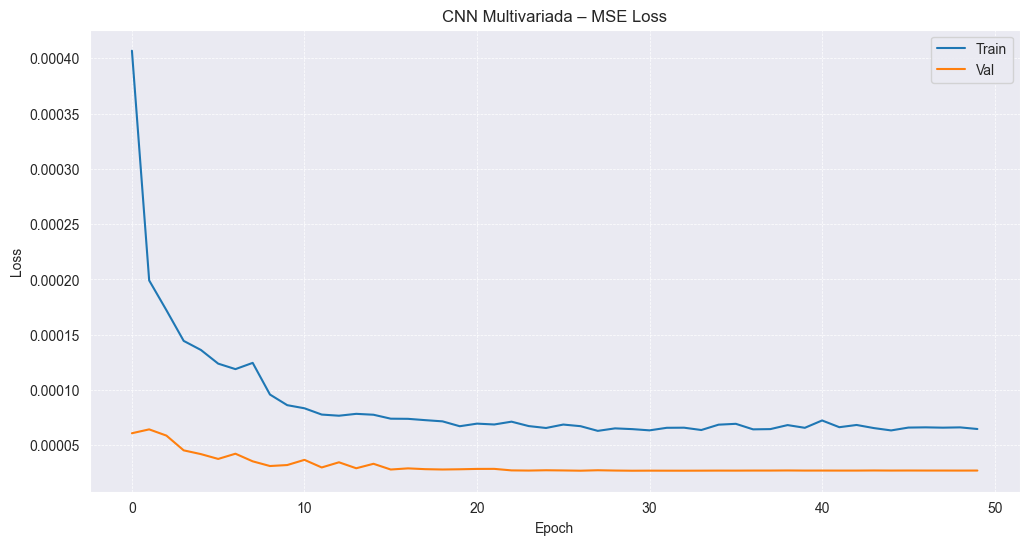

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_multi.history['loss'], label='Train')
plt.plot(history_cnn_multi.history['val_loss'], label='Val')
plt.title('CNN Multivariada – MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

La arquitectura es la misma que la CNN univariada, excepto que la primera capa Conv1D ahora toma 3 características de entrada en lugar de 1.


### 20. Evaluación CNN 1D Multivariada

1. *Desescalado*  
   - Cargamos el scaler_univariate para invertir la normalización de las predicciones.  
2. *Alineación*  
   - Ajustamos y_true eliminando las primeras 24 muestras (ventanas).  
3. *Métricas*  
   - Calculamos MAE, MSE, RMSE, MAPE (%) y R², y guardamos en cnn_multi_metrics.  
4. *Comparación*  
   - Mostramos una tabla comparativa entre SARIMA, MLP Univariado, CNN Univariado y CNN Multivariado.  
5. *Visualización*  
   - Graficamos los valores reales vs. el pronóstico multivariado en el conjunto de prueba.

In [116]:
# 20.1 Desescalar predicciones
scaler_uni = joblib.load('scaler_univariate.joblib')
y_pred_scaled = cnn_multi.predict(X_multi_test_seq)
y_pred = scaler_uni.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()   

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [117]:
# 20.2 Ajustar y_true (eliminar ventanas iniciales)
y_true = y_test.values.flatten()[window_size:]

In [118]:
# 20.3 Calcular métricas
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

cnn_multi_metrics = {
    'Model':     'CNN_Multivariate_v1',
    'MAE':       mae,
    'RMSE':      rmse,
    'MAPE (%)':  mape,
    'R2':        r2
}

In [119]:
# 20.4 Mostrar métricas y comparar
comparison = {
    'SARIMA':   sarima_metrics,
    'MLP_Uni':  mlp_uni_metrics,
    'CNN_Uni':  cnn_uni_metrics,
    'CNN_Multi': cnn_multi_metrics
}

print("Model       |   MAE   |  RMSE   | MAPE (%) |   R2")
for name, mets in comparison.items():
    print(f"{name:<12}| {mets['MAE']:.4f} | {mets['RMSE']:.4f} | {mets['MAPE (%)']:.2f}    | {mets['R2']:.4f}")

Model       |   MAE   |  RMSE   | MAPE (%) |   R2
SARIMA      | 4.8986 | 6.1031 | 17.57    | 0.0154
MLP_Uni     | 1.4849 | 2.0238 | 5.11    | 0.8751
CNN_Uni     | 2.0020 | 2.6469 | 7.08    | 0.7864
CNN_Multi   | 1.5984 | 2.0760 | 5.79    | 0.8686


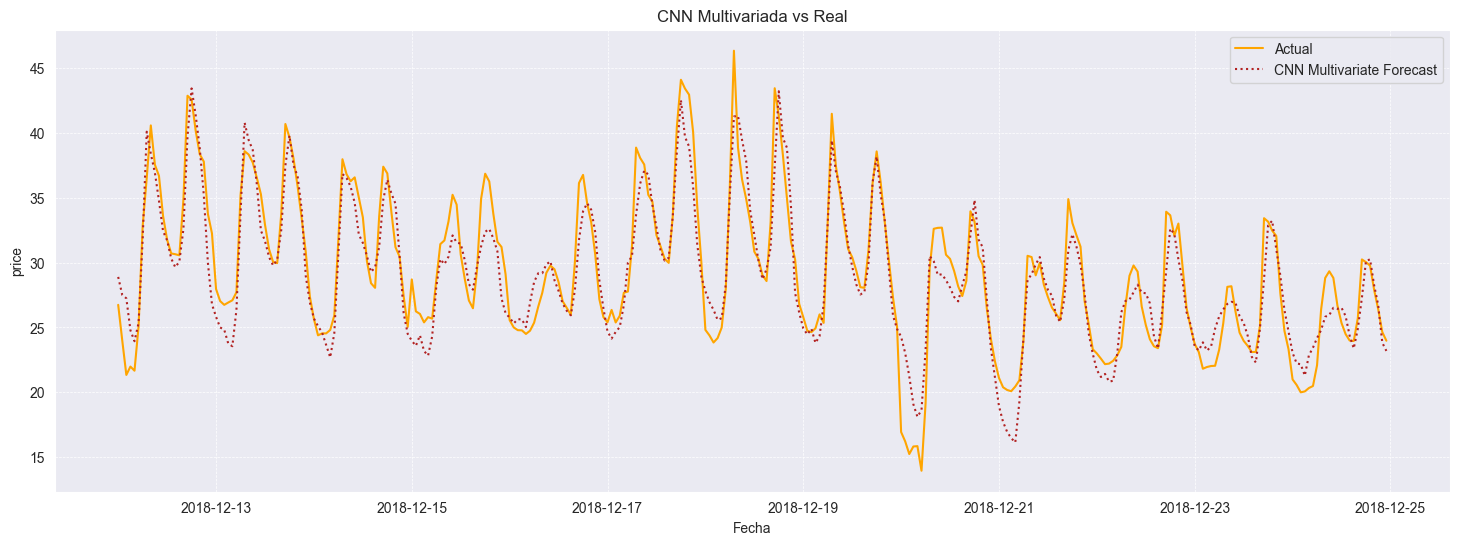

In [120]:
# 20.5 Gráfico: pronóstico vs real
idx = y_test.index[window_size:]
plt.figure(figsize=(18, 6))
plt.plot(idx, y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(idx, y_pred, label='CNN Multivariate Forecast', color='firebrick', linestyle=':', linewidth=1.5)
plt.title('CNN Multivariada vs Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 21. LSTM Univariada

- *Limpieza previa*: liberamos memoria con gc.collect() y limpiamos la sesión de TensorFlow.  
- *Arquitectura*  
  - Entrada: ventana de 24 pasos × 1 feature  
  - Capa LSTM: 64 unidades (ReLU)  
  - Capa densa: 32 unidades (ReLU)  
  - Salida: 1 unidad (regresión)  

- *Entrenamiento*  
  - Optimizador: Adam (lr=0.001)  
  - Pérdida: MSE  
  - Callbacks:  
    - EarlyStopping (patience=100)  
    - ModelCheckpoint (guarda mejor modelo)  
    - ReduceLROnPlateau (factor=0.2, patience=7)  
  - Épocas: 400  
  - Batch size: 32  
  - Validación interna: 20%  

- *Resultado*: gráfica de pérdida de entrenamiento vs. validación para evaluar ajuste y detectar overfitting.

In [121]:
# Definir la arquitectura
input_shape = (window_size, 1)
lstm_uni = Sequential(name="LSTM_Univariate")
lstm_uni.add(Input(shape=input_shape))
lstm_uni.add(LSTM(64, activation='relu'))
lstm_uni.add(Dense(32, activation='relu'))
lstm_uni.add(Dense(1))
lstm_uni.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [122]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    ModelCheckpoint("best_lstm_univariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [124]:
# Entrenamiento
history_lstm = lstm_uni.fit(
    X_uni_train_seq, y_uni_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.6045e-04 - val_loss: 4.8048e-05 - learning_rate: 0.0010
Epoch 2/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.4997e-04 - val_loss: 4.1113e-05 - learning_rate: 0.0010
Epoch 3/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1493e-04 - val_loss: 3.4839e-05 - learning_rate: 0.0010
Epoch 4/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0532e-04 - val_loss: 3.5890e-05 - learning_rate: 0.0010
Epoch 5/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0097e-04 - val_loss: 3.4174e-05 - learning_rate: 0.0010
Epoch 6/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9.9339e-05 - val_loss: 3.2749e-05 - learning_rate: 0.0010
Epoch 7/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9.7622e-05 - val_loss: 2.6156e-05 - learning_rate: 0.0010
Epoch 8/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9.6086e-05 - val_loss: 3.1121e-05 - learning_rate: 0.0010
Epoch 9/50
1302/1302 ━━━━━━━━━━━━━━━━━━━

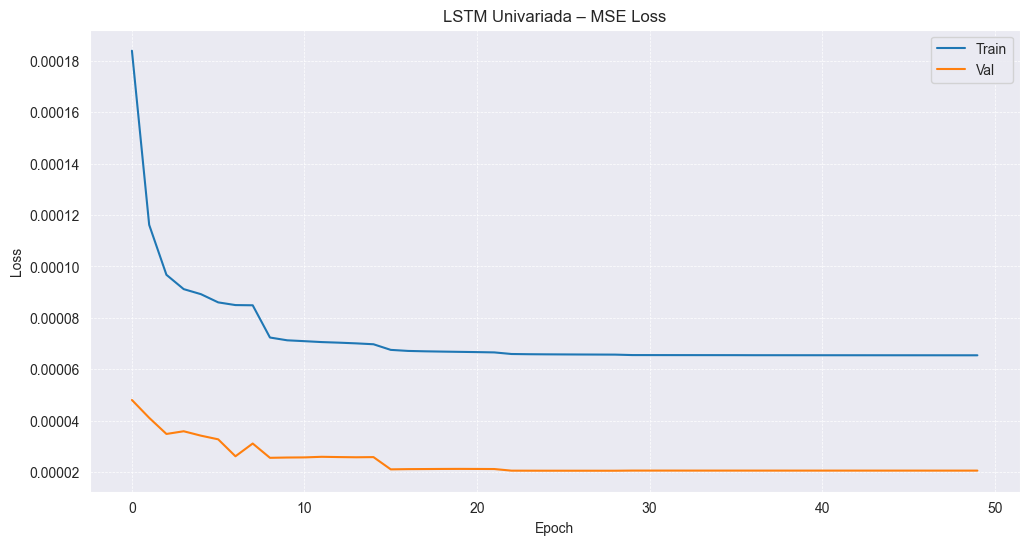

In [125]:
# Historial de pérdida
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Val')
plt.title('LSTM Univariada – MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 22. Evaluación de la LSTM Univariada

1. *Desescalado*: invertimos la normalización con scaler_univariate.  
2. *Alineación*: recortamos las primeras 24 muestras de y_true para empatar con las predicciones.  
3. *Métricas*: MAE, MSE, RMSE, MAPE (%) y R², almacenadas en lstm_uni_metrics.  
4. *Comparación*: tabla resumida de SARIMA, MLP univariado, CNN univariado y LSTM univariado.  
5. *Visualización*: gráfica de valores reales vs. predicción LSTM en el set de prueba.

In [126]:
# Desescalar predicciones
scaler_uni = joblib.load('scaler_univariate.joblib')
y_pred_scaled = lstm_uni.predict(X_uni_test_seq)
y_pred = scaler_uni.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [127]:
# Ajustar y_true eliminando la ventana inicial
y_true = y_test.values.flatten()[window_size:]

In [128]:
# Calcular métricas
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

lstm_uni_metrics = {
    'Model':      'LSTM_Univariate',
    'MAE':         mae,
    'RMSE':        rmse,
    'MAPE (%)':    mape,
    'R2':          r2
}

In [129]:
# Comparación de métricas
comparison = {
    'SARIMA':    sarima_metrics,
    'MLP_Uni':   mlp_uni_metrics,
    'CNN_Uni':   cnn_uni_metrics,
    'LSTM_Uni':  lstm_uni_metrics
}

print("Model      |   MAE   |  RMSE   | MAPE (%) |   R2")
for name, mets in comparison.items():
    print(f"{name:<10}| {mets['MAE']:.4f} | {mets['RMSE']:.4f} | {mets['MAPE (%)']:.2f}    | {mets['R2']:.4f}")

Model      |   MAE   |  RMSE   | MAPE (%) |   R2
SARIMA    | 4.8986 | 6.1031 | 17.57    | 0.0154
MLP_Uni   | 1.4849 | 2.0238 | 5.11    | 0.8751
CNN_Uni   | 2.0020 | 2.6469 | 7.08    | 0.7864
LSTM_Uni  | 1.6705 | 2.4529 | 5.47    | 0.8165


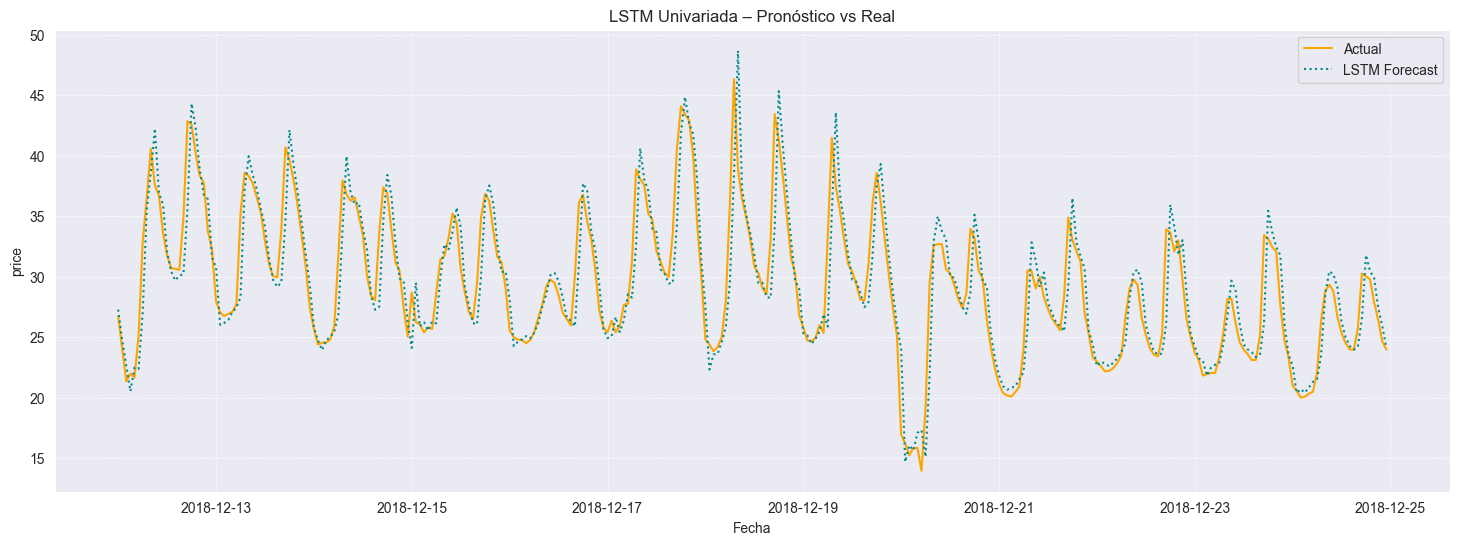

In [130]:
# Gráfico: pronóstico vs. real
idx = y_test.index[window_size:]
plt.figure(figsize=(18, 6))
plt.plot(idx, y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(idx, y_pred, label='LSTM Forecast', color='darkcyan', linestyle=':', linewidth=1.5)
plt.title('LSTM Univariada – Pronóstico vs Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 23. LSTM Multivariada

- *Arquitectura*  
  - Entrada: ventana de 24 pasos × 3 features  
  - Capa LSTM: 64 unidades (ReLU)  
  - Dropout: 20%  
  - Capa densa: 32 unidades (ReLU)  
  - Salida: 1 unidad (regresión)  

- *Entrenamiento*  
  - Optimizador: Adam (lr=0.001); Pérdida: MSE  
  - Callbacks:  
    - EarlyStopping (patience=100, restaura mejor peso)  
    - ModelCheckpoint (guarda mejor modelo)  
    - ReduceLROnPlateau (factor=0.2, patience=7)  
  - Épocas: 400; batch_size: 32; validación interna: 20%  

- *Resultado*  
  - Gráfica de entrenamiento vs. validación (MSE Loss) para evaluar posible overfitting.

In [131]:
# Definir modelo
input_shape = (window_size, X_multi_train_seq.shape[2])  # (24, 3)
lstm_multi = Sequential(name="LSTM_Multivariate")
lstm_multi.add(Input(shape=input_shape))
lstm_multi.add(LSTM(64, activation='relu'))
lstm_multi.add(Dropout(0.2))
lstm_multi.add(Dense(32, activation='relu'))
lstm_multi.add(Dense(1))
lstm_multi.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [132]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    ModelCheckpoint("best_lstm_multivariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [133]:
# Entrenamiento
history_lstm_multi = lstm_multi.fit(
    X_multi_train_seq, y_multi_train_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.1631e-04 - val_loss: 4.8416e-05 - learning_rate: 0.0010
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2.4203e-04 - val_loss: 4.7274e-05 - learning_rate: 0.0010
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.9852e-04 - val_loss: 3.6573e-05 - learning_rate: 0.0010
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.4956e-04 - val_loss: 3.8233e-05 - learning_rate: 0.0010
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.2402e-04 - val_loss: 4.4582e-05 - learning_rate: 0.0010
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.2332e-04 - val_loss: 3.0001e-05 - learning_rate: 0.0010
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.2543e-04 - val_loss: 2.6372e-05 - learning_rate: 0.0010
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.2371e-04 - val_loss: 3.2019e-05 - learning_rate: 0.0010
Epoch 9/30
1302/1302 ━━━━━━━━━━━━━━━━━━━

In [134]:
# Visualizar pérdida de entrenamiento vs. validación
plt.figure(figsize=(12, 6))
plt.plot(history_lstm_multi.history['loss'], label='Train')
plt.plot(history_lstm_multi.history['val_loss'], label='Val')
plt.title('LSTM Multivariada – MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 24. Evaluación de la LSTM Multivariada

1. *Desescalado*  
   - Usamos el scaler_univariate para invertir la normalización de las predicciones.  
2. *Alineación*  
   - Ajustamos y_true eliminando las primeras 24 muestras (ventanas).  
3. *Métricas*  
   - Calculamos MAE, MSE, RMSE, MAPE (%) y R², guardando los resultados en lstm_multi_metrics.  
4. *Comparación*  
   - Armamos una tabla con todas las métricas de los distintos modelos:  
     SARIMA, MLP univariado/multivariado, CNN univariado/multivariado y LSTM univariado/multivariado.  
5. *Visualización*  
   - Graficamos los valores reales vs. la predicción de la LSTM multivariada en el conjunto de prueba.

In [135]:
# 24.1 Desescalar predicciones
scaler_uni = joblib.load('scaler_univariate.joblib')
y_pred_scaled = lstm_multi.predict(X_multi_test_seq)
y_pred = scaler_uni.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [136]:
# 24.2 Alinear y_true eliminando ventanas iniciales
y_true = y_test.values.flatten()[window_size:]

In [137]:
# 24.3 Calcular métricas
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

lstm_multi_metrics = {
    'Model':      'LSTM_Multivariate',
    'MAE':         mae,
    'RMSE':        rmse,
    'MAPE (%)':    mape,
    'R2':          r2
}

In [138]:
# 24.4 Comparación de todas las métricas
comparison = {
    'SARIMA':      sarima_metrics,
    'MLP_Uni':     mlp_uni_metrics,
    'CNN_Uni':     cnn_uni_metrics,
    'MLP_Multi':   mlp_multi_metrics,
    'CNN_Multi':   cnn_multi_metrics,
    'LSTM_Uni':    lstm_uni_metrics,
    'LSTM_Multi':  lstm_multi_metrics
}

print("Model        |   MAE   |  RMSE   | MAPE (%) |   R2")
for name, mets in comparison.items():
    print(f"{name:<12}| {mets['MAE']:.4f} | {mets['RMSE']:.4f} | {mets['MAPE (%)']:.2f}    | {mets['R2']:.4f}")

Model        |   MAE   |  RMSE   | MAPE (%) |   R2
SARIMA      | 4.8986 | 6.1031 | 17.57    | 0.0154
MLP_Uni     | 1.4849 | 2.0238 | 5.11    | 0.8751
CNN_Uni     | 2.0020 | 2.6469 | 7.08    | 0.7864
MLP_Multi   | 1.8358 | 2.3307 | 6.68    | 0.8344
CNN_Multi   | 1.5984 | 2.0760 | 5.79    | 0.8686
LSTM_Uni    | 1.6705 | 2.4529 | 5.47    | 0.8165
LSTM_Multi  | 1.6141 | 2.1388 | 5.52    | 0.8605


In [139]:
# 24.5 Gráfico: pronóstico vs real
idx = y_test.index[window_size:]
plt.figure(figsize=(18, 6))
plt.plot(idx, y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(idx, y_pred, label='LSTM Multi Forecast', color='magenta', linestyle='-', linewidth=1.5)
plt.title('LSTM Multivariada – Pronóstico vs Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 25. ConvLSTM Univariada

- *Datos*  
  Transformamos X_uni_train_seq/test a shape 5D:  
  (samples, subseqs=4, rows=1, cols=6, features=1).

- *Arquitectura*  
  1. ConvLSTM2D: 64 filtros, kernel=(1,3), padding same  
  2. Flatten → Dense(32, ReLU) → Dropout(20%) → Salida(1)

- *Entrenamiento*  
  - Optimizador: Adam (lr=0.001)  
  - Pérdida: MSE  
  - Callbacks:  
    - EarlyStopping (patience=100)  
    - ModelCheckpoint (mejor modelo)  
    - ReduceLROnPlateau (factor=0.2, patience=7)  
  - Épocas: 400  
  - batch_size: 32  
  - validation_split: 0.2

- *Resultado*  
  Gráfica de pérdida de entrenamiento vs. validación para evaluar el ajuste.

In [140]:
# 25.1 Formatear datos a 5D: (samples, subseqs=4, rows=1, cols=6, features=1)
n_seq, n_steps, n_features = 4, 6, 1
X_conv_uni_train = X_uni_train_seq.reshape(-1, n_seq, 1, n_steps, n_features)
X_conv_uni_test  = X_uni_test_seq.reshape(-1, n_seq, 1, n_steps, n_features)

In [141]:
model_conv_lstm = Sequential(name="ConvLSTM_Univariate")
model_conv_lstm.add(Input(shape=(n_seq, 1, n_steps, n_features)))
model_conv_lstm.add(ConvLSTM2D(64, (1, 3), activation='relu', padding='same'))
model_conv_lstm.add(Flatten())
model_conv_lstm.add(Dense(32, activation='relu'))
model_conv_lstm.add(Dropout(0.2))
model_conv_lstm.add(Dense(1))
model_conv_lstm.compile(optimizer=Adam(0.001), loss='mse')

In [142]:
# 25.3 Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    ModelCheckpoint("best_convlstm_univariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [144]:
# 25.4 Entrenamiento
history_conv_uni = model_conv_lstm.fit(
    X_conv_uni_train, y_uni_train_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.3025e-04 - val_loss: 4.8633e-05 - learning_rate: 0.0010
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.7194e-04 - val_loss: 6.2757e-05 - learning_rate: 0.0010
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.8044e-04 - val_loss: 3.9807e-05 - learning_rate: 0.0010
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3700e-04 - val_loss: 3.2834e-05 - learning_rate: 0.0010
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3401e-04 - val_loss: 3.2732e-05 - learning_rate: 0.0010
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.4473e-04 - val_loss: 4.1932e-05 - learning_rate: 0.0010
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3683e-04 - val_loss: 4.3272e-05 - learning_rate: 0.0010
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.1391e-04 - val_loss: 3.5536e-05 - learning_rate: 0.0010
Epoch 9/30
1302/1302 ━━━━━━━━━━━━━━━━━━━

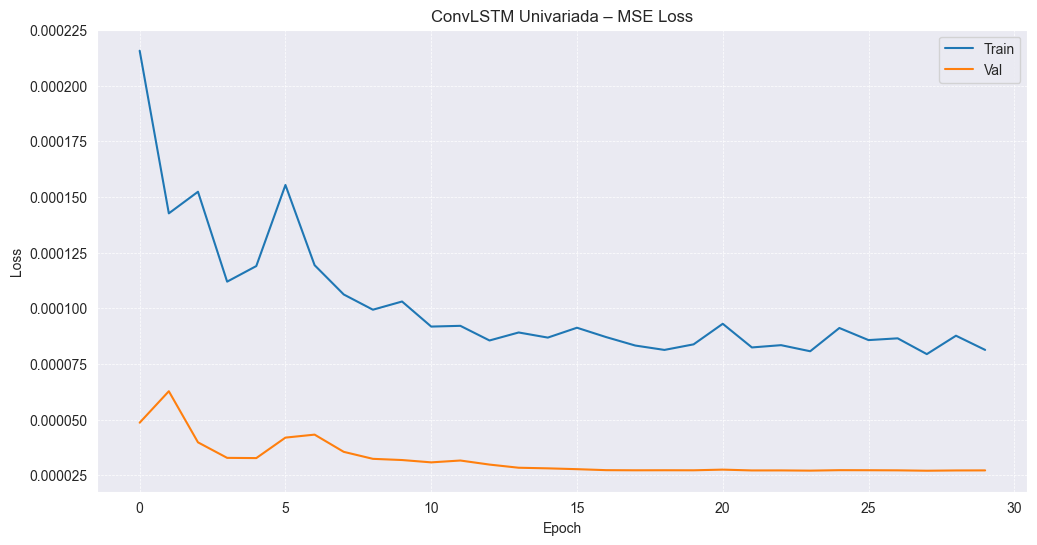

In [145]:
# 25.5 Historial de pérdida
plt.figure(figsize=(12, 6))
plt.plot(history_conv_uni.history['loss'], label='Train')
plt.plot(history_conv_uni.history['val_loss'], label='Val')
plt.title('ConvLSTM Univariada – MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 26. Evaluación ConvLSTM Univariada

1. *Desescalado*: invertimos la normalización con scaler_univariate.  
2. *Alineación*: recortamos las primeras 24 muestras de y_true para equiparar con y_pred.  
3. *Métricas*: calculamos MAE, MSE, RMSE, MAPE (%) y R², guardando en convlstm_uni_metrics.  
4. *Comparación*: mostramos una tabla con las métricas de SARIMA, MLP univariado, CNN univariado, LSTM univariado y ConvLSTM univariado.  
5. *Visualización*: graficamos valores reales vs. predicción ConvLSTM en el conjunto de prueba.

In [146]:
# 26.1 Desescalado de predicciones
scaler_uni = joblib.load('scaler_univariate.joblib')
y_pred_scaled = model_conv_lstm.predict(X_conv_uni_test)
y_pred = scaler_uni.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [147]:
# 26.2 Alineación de y_true
y_true = y_test.values.flatten()[window_size:]

In [148]:
# 26.3 Cálculo de métricas
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

convlstm_uni_metrics = {
    'Model':       'ConvLSTM_Univariate',
    'MAE':          mae,
    'RMSE':         rmse,
    'MAPE (%)':     mape,
    'R2':           r2
}

In [149]:
# 26.4 Comparación de métricas
comparison = {
    'SARIMA':       sarima_metrics,
    'MLP_Uni':      mlp_uni_metrics,
    'CNN_Uni':      cnn_uni_metrics,
    'LSTM_Uni':     lstm_uni_metrics,
    'ConvLSTM_Uni': convlstm_uni_metrics
}

print("Model           |   MAE   |  RMSE   | MAPE (%) |   R2")
for name, mets in comparison.items():
    print(f"{name:<15}| {mets['MAE']:.4f} | {mets['RMSE']:.4f} | {mets['MAPE (%)']:.2f}    | {mets['R2']:.4f}")

Model           |   MAE   |  RMSE   | MAPE (%) |   R2
SARIMA         | 4.8986 | 6.1031 | 17.57    | 0.0154
MLP_Uni        | 1.4849 | 2.0238 | 5.11    | 0.8751
CNN_Uni        | 2.0020 | 2.6469 | 7.08    | 0.7864
LSTM_Uni       | 1.6705 | 2.4529 | 5.47    | 0.8165
ConvLSTM_Uni   | 1.5895 | 2.1973 | 5.47    | 0.8528


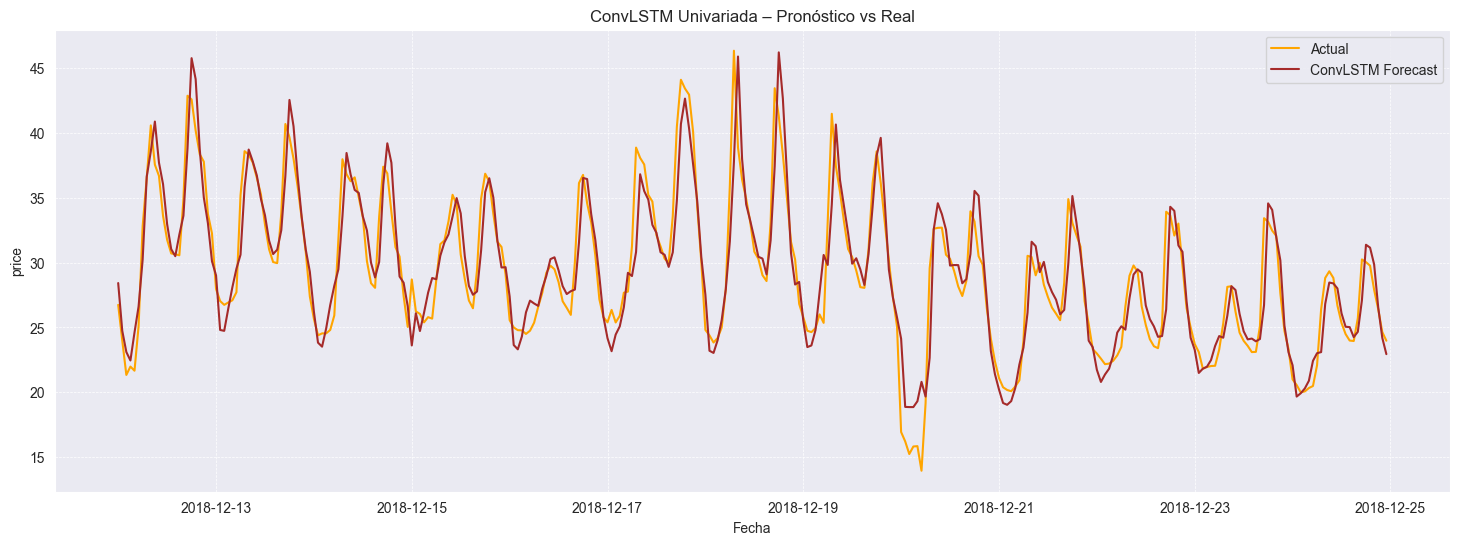

In [150]:
# 26.5 Gráfico: pronóstico vs. real
idx = y_test.index[window_size:]
plt.figure(figsize=(18,6))
plt.plot(idx, y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(idx, y_pred, label='ConvLSTM Forecast', color='brown', linewidth=1.5)
plt.title('ConvLSTM Univariada – Pronóstico vs Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 27. ConvLSTM Multivariada

- *Datos*  
  Convertimos X_multi_train_seq/test a forma 5D:  
  (samples, subseqs=4, rows=1, cols=6, features=3).

- *Arquitectura*  
  1. ConvLSTM2D: 64 filtros, kernel=(1,3), padding='same'  
  2. Flatten → Dense(32, ReLU) → Dropout(20%) → Salida (Dense(1))

- *Entrenamiento*  
  - Optimizer: Adam (lr=0.001)  
  - Loss: MSE  
  - Callbacks:  
    - EarlyStopping (patience=100)  
    - ModelCheckpoint (mejor modelo)  
    - ReduceLROnPlateau (factor=0.2, patience=7)  
  - Épocas: 400  
  - Batch size: 32  
  - Validación interna: 20%

- *Resultado*  
  Gráfica de evolución de la pérdida de entrenamiento y validación.

In [151]:
# 27.1 Preparar datos a 5D: (samples, subseqs=4, rows=1, cols=6, features=3)
n_seq, n_steps, n_feat = 4, 6, X_multi_train_seq.shape[2]
X_conv_multi_train = X_multi_train_seq.reshape(-1, n_seq, 1, n_steps, n_feat)
X_conv_multi_test  = X_multi_test_seq.reshape(-1, n_seq, 1, n_steps, n_feat)

In [152]:
# 27.2 Definir y compilar modelo
model_conv_multi = Sequential(name="ConvLSTM_Multivariate")
model_conv_multi.add(Input(shape=(n_seq, 1, n_steps, n_feat)))
model_conv_multi.add(ConvLSTM2D(64, (1, 3), activation='relu', padding='same'))
model_conv_multi.add(Flatten())
model_conv_multi.add(Dense(32, activation='relu'))
model_conv_multi.add(Dropout(0.2))
model_conv_multi.add(Dense(1))
model_conv_multi.compile(optimizer=Adam(0.001), loss='mse')

In [153]:
# 27.3 Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    ModelCheckpoint("best_convlstm_multivariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [154]:
# 27.4 Entrenamiento
history_conv_multi = model_conv_multi.fit(
    X_conv_multi_train, y_multi_train_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 5.2236e-04 - val_loss: 6.1351e-05 - learning_rate: 0.0010
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 2.7115e-04 - val_loss: 5.7221e-05 - learning_rate: 0.0010
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 2.0333e-04 - val_loss: 4.6293e-05 - learning_rate: 0.0010
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.7625e-04 - val_loss: 3.7795e-05 - learning_rate: 0.0010
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.4369e-04 - val_loss: 4.2488e-05 - learning_rate: 0.0010
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.4244e-04 - val_loss: 2.9642e-05 - learning_rate: 0.0010
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0905e-04 - val_loss: 3.1506e-05 - learning_rate: 0.0010
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1652e-04 - val_loss: 3.4619e-05 - learning_rate: 0.0010
Epoch 9/30
1302/1302 ━━━━━━━━━━━━━━━

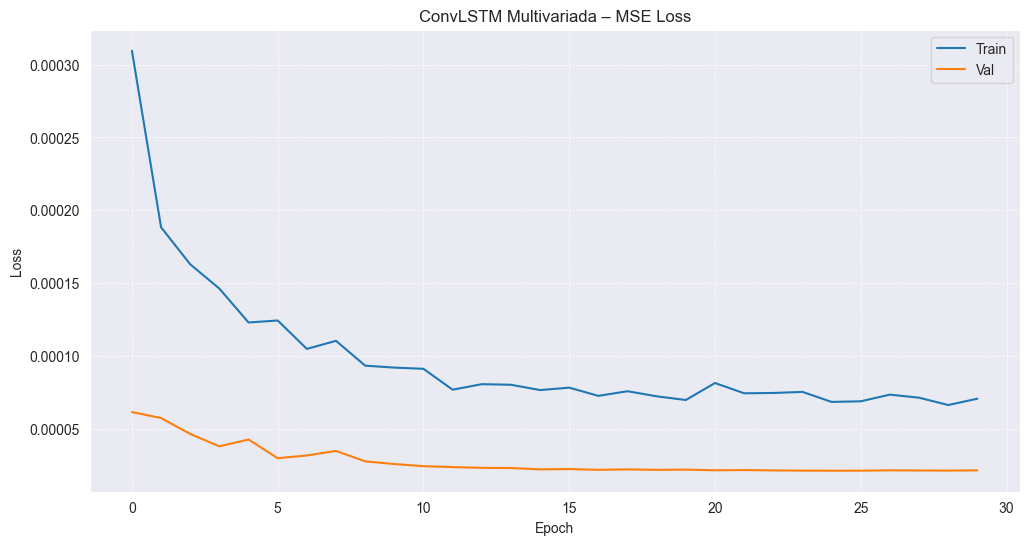

In [155]:
# 27.5 Historial de pérdida
plt.figure(figsize=(12, 6))
plt.plot(history_conv_multi.history['loss'], label='Train')
plt.plot(history_conv_multi.history['val_loss'], label='Val')
plt.title('ConvLSTM Multivariada – MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 28. Resumen final de modelos de pronóstico

Se comparan las métricas clave (MAE, RMSE, MAPE y R²) de todos los modelos ajustados.  
El gráfico ilustra la predicción final del modelo ConvLSTM multivariado frente a los valores reales del conjunto de prueba.

In [161]:
# 1. Desescalar predicciones de ConvLSTM multivariada
scaler_uni = joblib.load('scaler_univariate.joblib')
y_pred = scaler_uni.inverse_transform(
    model_conv_multi.predict(X_conv_multi_test).reshape(-1,1)
).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [162]:
# 2. Ajustar y_true recortando las primeras ventanas
y_true = y_test.values.flatten()[window_size:]

In [163]:
# 3. Calcular métricas para ConvLSTM multivariada
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

In [164]:
convlstm_multi_metrics = {
    'Model':       'ConvLSTM_Multivariate',
    'MAE':          mae,
    'RMSE':         rmse,
    'MAPE (%)':     mape,
    'R2':           r2
}

In [165]:
# 4.01 Comparación de métricas
all_metrics = {
    'SARIMA':       sarima_metrics,
    'MLP_Uni':      mlp_uni_metrics,
    'CNN_Uni':      cnn_uni_metrics,
    'LSTM_Uni':     lstm_uni_metrics,
    'ConvLSTM_Uni': convlstm_uni_metrics,
    'ConvLSTM_Multivariate': convlstm_multi_metrics
}

In [167]:
# 4. Reunir todas las métricas
convlstm_uni_metrics = {
    'Model':      'ConvLSTM_Multivariate',
    'MAE':         mae,
    'RMSE':        rmse,
    'MAPE (%)':    mape,
    'R2':          r2
}
metrics_df = pd.DataFrame.from_dict(all_metrics, orient='index')[['Model', 'MAE', 'RMSE', 'MAPE (%)', 'R2']]

In [168]:
metrics_df  

Model       MAE      RMSE   MAPE (%)  \
SARIMA                     SARIMA_Univariate  4.898556  6.103051  17.565515   
MLP_Uni                    MLP_Univariate_v1  1.484908  2.023789   5.112749   
CNN_Uni                    CNN_Univariate_v1  2.001985  2.646914   7.082827   
LSTM_Uni                     LSTM_Univariate  1.670482  2.452911   5.469496   
ConvLSTM_Uni             ConvLSTM_Univariate  1.589501  2.197305   5.467516   
ConvLSTM_Multivariate  ConvLSTM_Multivariate  1.771258  2.351391   6.170591   

                             R2  
SARIMA                 0.015446  
MLP_Uni                0.875103  
CNN_Uni                0.786350  
LSTM_Uni               0.816521  
ConvLSTM_Uni           0.852768  
ConvLSTM_Multivariate  0.831394

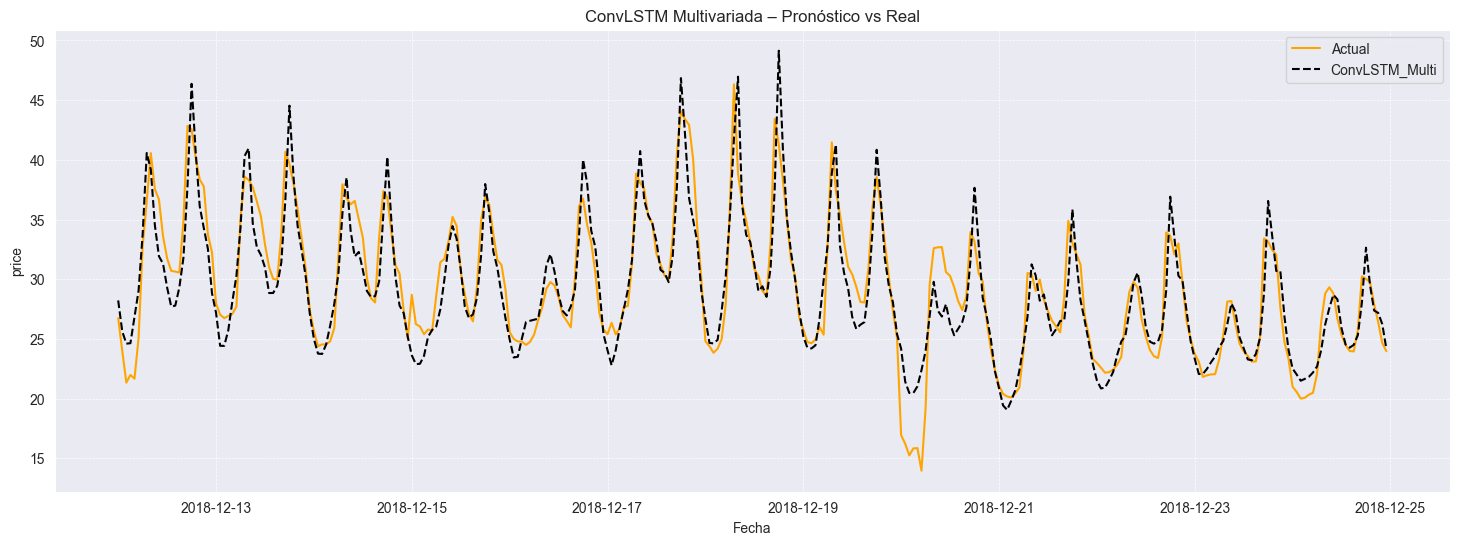

In [169]:
# 6. Graficar última predicción vs. real
plt.figure(figsize=(18,6))
plt.plot(y_test.index[window_size:], y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(y_test.index[window_size:], y_pred, label='ConvLSTM_Multi', color='black', linestyle='--', linewidth=1.5)
plt.title('ConvLSTM Multivariada – Pronóstico vs Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 29. Optimización de Hiperparámetros del MLP Univariado

Definimos una función objetivo para Optuna que:

1. Limpia la sesión de TensorFlow y libera memoria.
2. Sugiere:
   - Número de capas ocultas (n_layers).
   - Unidades por capa (n_units_i).
   - Tasa de aprendizaje (learning_rate).
   - Tasa de dropout (dropout_rate).
   - Función de activación (activation).
3. Construye un Sequential MLP con esas opciones.
4. Compila con Adam y entrena (hasta 300 épocas, batch=64, validación interna 20%, EarlyStopping paciencia=100).
5. Devuelve la mínima pérdida de validación (val_loss) como objetivo a minimizar.

Luego creamos un estudio Optuna (direction='minimize') y corremos 50 trials o hasta 40 minutos.  
Al final, imprimimos el número y valor de la mejor pérdida, junto a sus hiperparámetros.

In [170]:
def objective_mlp_uni(trial):
    # limpiar sesión y recolectar memoria
    tf.keras.backend.clear_session()
    gc.collect()
    
    # hiperparámetros a optimizar
    n_layers       = trial.suggest_int("n_layers",        1,   3)
    layer_units    = [trial.suggest_int(f"n_units_{i}",  32, 256, log=True)
                      for i in range(n_layers)]
    learning_rate  = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    dropout_rate   = trial.suggest_float("dropout_rate",  0.0,  0.5)
    activation     = trial.suggest_categorical("activation", ["relu", "tanh"])
    
    # construir modelo
    model = Sequential()
    input_dim = X_uni_train_flat.shape[1]
    for i, units in enumerate(layer_units):
        if i == 0:
            model.add(Dense(units, activation=activation,
                            input_shape=(input_dim,)))
        else:
            model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    # compilar y entrenar
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=100,
                       restore_best_weights=True, verbose=0)
    history = model.fit(
        X_uni_train_flat, y_uni_train,
        epochs=50, batch_size=64,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    
    # devolver la mejor pérdida de validación
    return min(history.history['val_loss'])

In [171]:
# ejecutar el estudio
study = optuna.create_study(direction='minimize',
                            study_name="mlp_univariate_opt")
study.optimize(objective_mlp_uni, n_trials=20, timeout=2400)

[I 2025-05-14 18:38:00,914] A new study created in memory with name: mlp_univariate_opt


[I 2025-05-14 18:38:40,906] Trial 0 finished with value: 1.977644205908291e-05 and parameters: {'n_layers': 1, 'n_units_0': 232, 'learning_rate': 0.00018758573775537203, 'dropout_rate': 0.2204529252569679, 'activation': 'tanh'}. Best is trial 0 with value: 1.977644205908291e-05.
[I 2025-05-14 18:39:15,074] Trial 1 finished with value: 2.9330270990612917e-05 and parameters: {'n_layers': 3, 'n_units_0': 33, 'n_units_1': 34, 'n_units_2': 35, 'learning_rate': 0.006126659548749089, 'dropout_rate': 0.3157941460419194, 'activation': 'tanh'}. Best is trial 0 with value: 1.977644205908291e-05.
[I 2025-05-14 18:39:46,074] Trial 2 finished with value: 3.1810403015697375e-05 and parameters: {'n_layers': 3, 'n_units_0': 86, 'n_units_1': 195, 'n_units_2': 52, 'learning_rate': 0.001087430314513551, 'dropout_rate': 0.2742626313332991, 'activation': 'relu'}. Best is trial 0 with value: 1.977644205908291e-05.
[I 2025-05-14 18:40:07,959] Trial 3 finished with value: 1.9320654246257618e-05 and parameters:

In [172]:
# resultados
best = study.best_trial
print(f"Mejor trial #{best.number} → val_loss={best.value:.4f}")
for param, val in best.params.items():
    print(f"  {param}: {val}")

Mejor trial #5 → val_loss=0.0000
  n_layers: 1
  n_units_0: 189
  learning_rate: 0.0035213311580044684
  dropout_rate: 0.10783202106506534
  activation: relu


### 30. Evaluación del MLP Univariado Optimizado

1. *Desescalado y Alineación*  
   - Invertimos la normalización de las predicciones.  
   - Recortamos las primeras 24 muestras de y_true para emparejar con las predicciones.  
2. *Cálculo de métricas*  
   - MAE, RMSE, MAPE (%) y R², almacenados en mlp_opt_metrics.  
3. *Actualización de tabla*  
   - Concatenamos estas métricas al DataFrame metrics_df que contiene todos los modelos.  
4. *Visualización*  
   - Graficamos la predicción optimizada frente a los valores reales del conjunto de prueba.

In [178]:
# Definir modelo con los mejores hiperparámetros
input_dim = X_uni_train_flat.shape[1]  # Asegúrate que esto coincide con tus datos

model_mlp_uni_opt = Sequential(name="optuna_mlp_univariate_optimized")

# Capa de entrada (única capa oculta según n_layers=1)
model_mlp_uni_opt.add(Dense(189, activation='relu', input_shape=(input_dim,)))
model_mlp_uni_opt.add(Dropout(0.1078))  # dropout_rate óptimo

# Capa de salida (univariada)
model_mlp_uni_opt.add(Dense(1))

# Compilar con learning_rate óptimo
optimizer = Adam(learning_rate=0.003521)  # Valor óptimo encontrado
model_mlp_uni_opt.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']  # Puedes añadir más métricas si necesitas
)

In [179]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    ModelCheckpoint("optuna_mlp_univariate.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

In [180]:
# Entrenamiento
history_uni = model_mlp_uni_opt.fit(
    X_uni_train_flat, y_uni_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3701e-04 - mae: 0.0084 - val_loss: 4.1219e-05 - val_mae: 0.0049 - learning_rate: 0.0035
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - loss: 1.6247e-04 - mae: 0.0059 - val_loss: 3.1665e-05 - val_mae: 0.0041 - learning_rate: 0.0035
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 1.5050e-04 - mae: 0.0052 - val_loss: 4.4967e-05 - val_mae: 0.0052 - learning_rate: 0.0035
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - loss: 1.2584e-04 - mae: 0.0049 - val_loss: 3.5580e-05 - val_mae: 0.0045 - learning_rate: 0.0035
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - loss: 1.3030e-04 - mae: 0.0050 - val_loss: 2.8748e-05 - val_mae: 0.0038 - learning_rate: 0.0035
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - loss: 1.3333e-04 - mae: 0.0052 - val_loss: 3.4899e-05 - val_mae: 0.0046 - learning_rate: 0.0035
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - loss: 1.2565e-04 - mae: 0.0048 - v

In [181]:
# 1. Desescalar y recortar predicciones
y_pred = scaler_uni.inverse_transform(
    model_mlp_uni_opt.predict(X_uni_test_flat).reshape(-1,1)
).flatten()
y_true = y_test.values.flatten()[window_size:]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [182]:
# 2. Calcular métricas
mae   = mean_absolute_error(y_true, y_pred)
rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
r2    = r2_score(y_true, y_pred)
mask  = y_true != 0
mape  = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean() * 100) if mask.any() else np.nan

mlp_opt_metrics = {
    'Model':    'MLP_Uni_Optimized',
    'MAE':       mae,
    'RMSE':      rmse,
    'MAPE (%)':  mape,
    'R2':        r2
}

In [183]:
# 3. Actualizar DataFrame de métricas
metrics_df = pd.concat(
    [metrics_df, pd.DataFrame([mlp_opt_metrics])],
    ignore_index=True
)

In [185]:
# 4. Mostrar tabla actualizada
metrics_df

Model       MAE      RMSE   MAPE (%)        R2
0      SARIMA_Univariate  4.898556  6.103051  17.565515  0.015446
1      MLP_Univariate_v1  1.484908  2.023789   5.112749  0.875103
2      CNN_Univariate_v1  2.001985  2.646914   7.082827  0.786350
3        LSTM_Univariate  1.670482  2.452911   5.469496  0.816521
4    ConvLSTM_Univariate  1.589501  2.197305   5.467516  0.852768
5  ConvLSTM_Multivariate  1.771258  2.351391   6.170591  0.831394
6      MLP_Uni_Optimized  1.536684  2.119821   5.176490  0.862968

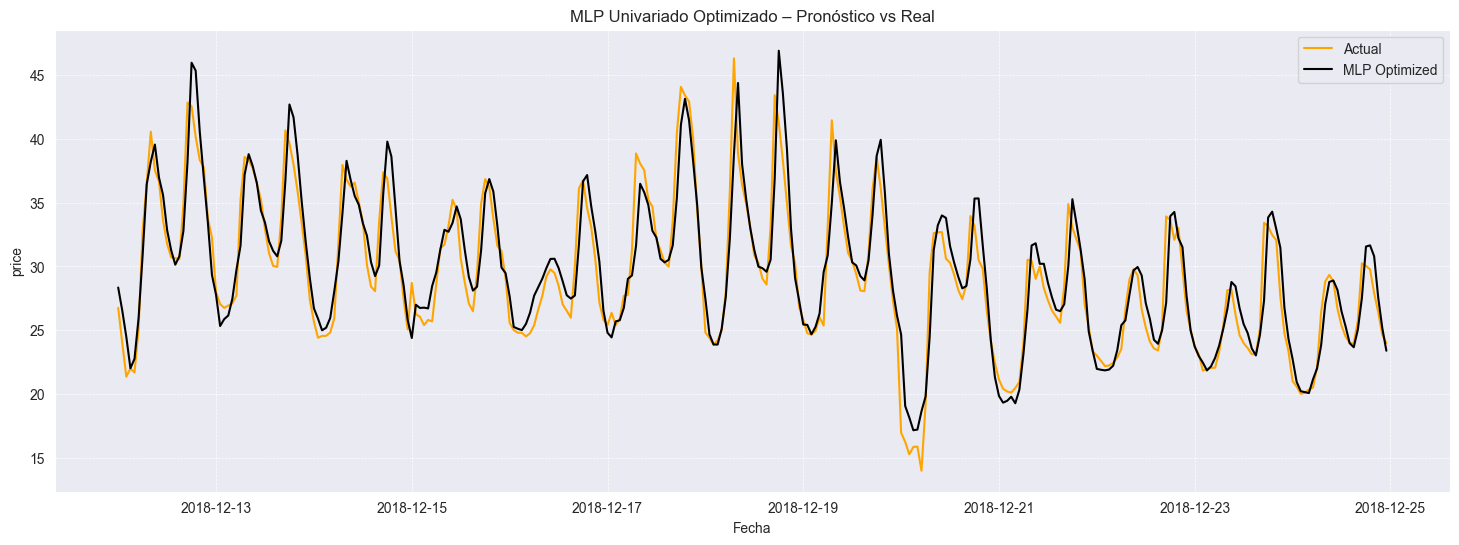

In [186]:
# 5. Gráfico: pronóstico optimizado vs. real
idx = y_test.index[window_size:]
plt.figure(figsize=(18,6))
plt.plot(idx, y_true, label='Actual', color='orange', linewidth=1.5)
plt.plot(idx, y_pred, label='MLP Optimized', color='black', linewidth=1.5)
plt.title('MLP Univariado Optimizado – Pronóstico vs Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 31. Ingeniería de Características: Etiquetas de Cambio de Precio

- *price_diff*: diferencia horaria de la serie de precios.  
- *Umbral*: 0.1 · desviación estándar de price_diff, para distinguir cambios pequeños (estable) de grandes (sube/baja).  
- *Etiquetas*:
  - *Sube*: incremento mayor que el umbral.  
  - *Baja*: decremento menor que el negativo del umbral.  
  - *Estable*: cambio dentro de ±umbral.  
- Eliminamos las filas sin etiqueta (NaN) para preparar el dataset de clasificación.  
- Graficamos la *distribución de clases* para comprobar el balance entre ‘Sube’, ‘Estable’ y ‘Baja’.

In [187]:
# Copiar df para no alterar el original
df_feat = df.copy()

# 1. Diferencia horaria de precio
df_feat['price_diff'] = df_feat[target_variable].diff()

In [188]:
# 2. Umbral basado en la desviación estándar de price_diff
std_diff = df_feat['price_diff'].std()
threshold = 0.1 * std_diff

In [189]:
# 3. Función para etiquetar el cambio
def label_change(x, thr):
    if pd.isna(x):
        return None
    if x > thr:
        return 'Sube'
    if x < -thr:
        return 'Baja'
    return 'Estable'

df_feat['price_change_label'] = df_feat['price_diff'].apply(lambda x: label_change(x, threshold))

In [190]:
# 4. DataFrame listo para clasificación (sin NaNs en la etiqueta)
df_cls = df_feat.dropna(subset=['price_change_label'])

In [191]:
# 5. Distribución de clases (porcentaje)
dist = df_cls['price_change_label'].value_counts(normalize=True) * 100

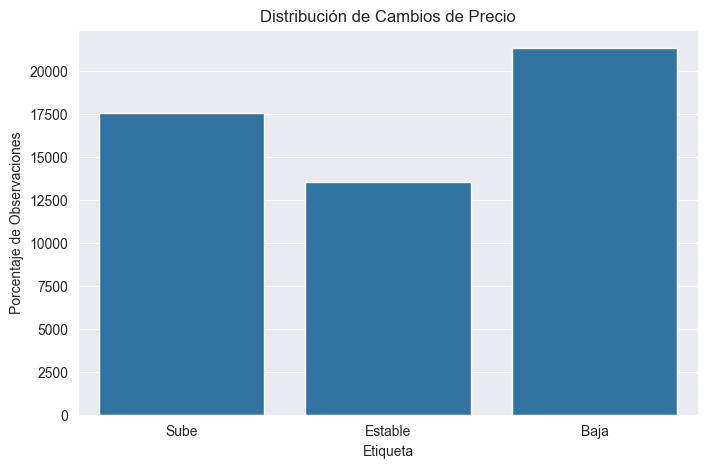

In [194]:
import seaborn as sns
# 6. Gráfico de la distribución
plt.figure(figsize=(8, 5))
sns.countplot(
    x='price_change_label',
    data=df_cls,
    order=['Sube', 'Estable', 'Baja']
)
plt.title('Distribución de Cambios de Precio')
plt.ylabel('Porcentaje de Observaciones')
plt.xlabel('Etiqueta')
plt.show()

### 32. Preparación de datos para clasificación

1. *Codificación*: transformamos price_change_label a label_encoded con LabelEncoder.  
2. *Train/Test split*: usamos las últimas 336 horas para prueba (igual que en pronóstico).  
3. *Escalado*: aplicamos MinMaxScaler a price, system_load_forecast y zonal_load_forecast, ajustando solo en train.  
4. *Windowing*: generamos secuencias de longitud 24 horas con create_sequences.  
5. *Aplanado*: convertimos las secuencias a matrices 2D para modelos ML clásicos y MLP.  
6. *Guardado*: persistimos el scaler_clf y el LabelEncoder para uso posterior.

In [198]:
# 1. Codificar etiquetas
le = LabelEncoder()
df_cls['label_encoded'] = le.fit_transform(df_cls['price_change_label'])

In [202]:
df_cls

price  system_load_forecast  zonal_load_forecast  \
Date                                                                        
2013-01-01 01:00:00  23.554578               82128.0              10942.0   
2013-01-01 02:00:00  22.122277               80729.0              10639.0   
2013-01-01 03:00:00  21.592066               80248.0              10476.0   
2013-01-01 04:00:00  21.546501               80850.0              10445.0   
2013-01-01 05:00:00  21.962992               82642.0              10515.0   
...                        ...                   ...                  ...   
2018-12-24 19:00:00  29.761473               94939.0              11246.0   
2018-12-24 20:00:00  27.897676               94035.0              11070.0   
2018-12-24 21:00:00  26.405903               92923.0              10963.0   
2018-12-24 22:00:00  24.646744               90970.0              10802.0   
2018-12-24 23:00:00  23.980222               88037.0              10419.0   

                     price_seasonal_diff  price_diff price_change_label  \
Date                                                                      
2013-01-01 01:00:00                  NaN   -1.909633               Baja   
2013-01-01 02:00:00                  NaN   -1.432301               Baja   
2013-01-01 03:00:00                  NaN   -0.530211            Estable   
2013-01-01 04:00:00                  NaN   -0.045565            Estable   
2013-01-01 05:00:00                  NaN    0.416491            Estable   
...                                  ...         ...                ...   
2018-12-24 19:00:00            -2.700497   -0.270963            Estable   
2018-12-24 20:00:00            -4.154503   -1.863797               Baja   
2018-12-24 21:00:00            -1.226444   -1.491773               Baja   
2018-12-24 22:00:00            -0.099309   -1.759159               Baja   
2018-12-24 23:00:00             0.646723   -0.666522            Estable   

                     label_encoded  
Date                                
2013-01-01 01:00:00              0  
2013-01-01 02:00:00              0  
2013-01-01 03:00:00              1  
2013-01-01 04:00:00              1  
2013-01-01 05:00:00              1  
...                            ...  
2018-12-24 19:00:00              1  
2018-12-24 20:00:00              0  
2018-12-24 21:00:00              0  
2018-12-24 22:00:00              0  
2018-12-24 23:00:00              1  

[52415 rows x 7 columns]

In [199]:
# 2. División cronológica train/test
train_clf = df_cls.iloc[:-n_test_hours]
test_clf  = df_cls.iloc[-n_test_hours:]

In [232]:
feature_variables=['system_load_forecast', 'zonal_load_forecast','price']

In [235]:
# 3. Escalar features
features = feature_variables 
scaler_clf = MinMaxScaler()
X_train = scaler_clf.fit_transform(train_clf[features])
X_test  = scaler_clf.transform(test_clf[features])

y_train = train_clf['label_encoded'].values
y_test  = test_clf['label_encoded'].values

In [236]:
# 4. Crear secuencias (windowing)
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size, 1)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test,  window_size, 1)

In [237]:
# 5. Aplanar para ML/MLP
X_train_flat = X_train_seq.reshape(len(X_train_seq), -1)
X_test_flat  = X_test_seq.reshape(len(X_test_seq),   -1)
y_train_ml   = y_train_seq.flatten()
y_test_ml    = y_test_seq.flatten()

In [238]:
# 6. Guardar scaler y encoder
joblib.dump(scaler_clf, 'scaler_classification.joblib')
joblib.dump(le,          'label_encoder.joblib')

['label_encoder.joblib']

### 33. Modelos clásicos de ML para clasificación

- *Clasificadores usados*:  
  - KNN (k=5)  
  - CART (árbol de decisión)  
  - SVM (kernel lineal)  
  - Naive Bayes  
  - Random Forest (100 árboles)  
  - Extra Trees (100 árboles)  

- *Flujo*:  
  1. Entrenamos cada modelo en X_train_flat/y_train_ml.  
  2. Medimos tiempo de entrenamiento y predicción.  
  3. Calculamos *Accuracy, **F1 Macro* y *F1 Weighted*.  
  4. Almacenamos todo en ml_results_df y lo ordenamos por *Accuracy*.

- *Preparado para comparar* con los modelos de deep learning en las siguientes celdas.

In [239]:
# 1. Definir clasificadores
models = {
    'KNN':    KNeighborsClassifier(n_neighbors=5),
    'CART':   DecisionTreeClassifier(random_state=SEED),
    'SVM':    SVC(kernel='linear', random_state=SEED),
    'NB':     GaussianNB(),
    'RF':     RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
    'ET':     ExtraTreesClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
}

In [240]:
import time
from sklearn.metrics import accuracy_score, f1_score
# 2. Entrenar, predecir y calcular métricas
results = []
for name, clf in models.items():
    t0 = time.time()
    clf.fit(X_train_flat, y_train_ml)
    train_time = time.time() - t0

    t1 = time.time()
    preds = clf.predict(X_test_flat)
    predict_time = time.time() - t1

    acc = accuracy_score(y_test_ml, preds)
    f1_m   = f1_score(y_test_ml, preds, average='macro')
    f1_w   = f1_score(y_test_ml, preds, average='weighted')

    results.append({
        'Model':       name,
        'Accuracy':    acc,
        'F1_Macro':    f1_m,
        'F1_Weighted': f1_w,
        'Train_s':     train_time,
        'Predict_s':   predict_time
    })

In [241]:
# 3. Crear DataFrame con los resultados y ordenar por Accuracy
ml_results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

In [242]:
ml_results_df

Model  Accuracy  F1_Macro  F1_Weighted     Train_s  Predict_s
5    ET  0.746795  0.745784     0.741058    0.763991   0.019538
4    RF  0.743590  0.736074     0.733190    4.493797   0.036121
2   SVM  0.698718  0.696985     0.689996  151.768699   0.223264
0   KNN  0.663462  0.674356     0.663649    0.008036   0.033639
1  CART  0.647436  0.643068     0.644195    7.706360   0.000000
3    NB  0.387821  0.250816     0.263658    0.031958   0.000000

### 34. MLP de Clasificación (v1)

- *Entrada*: secuencias aplanadas de 24h × 3 features → 72 dimensiones.  
- *Arquitectura*:
  - Dense(64) → ReLU  
  - Dropout 20%  
  - Dense(32) → ReLU  
  - Dropout 20%  
  - Dense(3) → Softmax  
- *Compilación*: Adam(lr=0.001), sparse_categorical_crossentropy, métrica accuracy.  
- *Callbacks*:
  - EarlyStopping (val_accuracy, paciencia=100)  
  - ModelCheckpoint (mejor val_accuracy)  
  - ReduceLROnPlateau (val_accuracy, factor=0.2, paciencia=10)  
- *Entrenamiento*: 400 epochs, batch_size=64, validación 20%.  
- *Salida*: gráficas de entrenamiento vs. validación para Accuracy y Loss.

In [243]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)    

{'Baja': 0, 'Estable': 1, 'Sube': 2}


In [244]:
# Definir y compilar modelo
n_classes = len(label_mapping)
input_dim = X_train_flat.shape[1]

mlp_clf = Sequential(name="MLP_Classifier")
mlp_clf.add(Dense(64, activation='relu', input_shape=(input_dim,)))
mlp_clf.add(Dropout(0.2))
mlp_clf.add(Dense(32, activation='relu'))
mlp_clf.add(Dropout(0.2))
mlp_clf.add(Dense(n_classes, activation='softmax'))

mlp_clf.compile(
    optimizer=Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [245]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True, mode='max'),
    ModelCheckpoint("best_mlp_classification.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-6, mode='max')
]

In [246]:
# Entrenamiento
history_mlp_clf = mlp_clf.fit(
    X_train_flat, y_train_ml,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5919 - loss: 0.8870 - val_accuracy: 0.6704 - val_loss: 0.7644 - learning_rate: 0.0010
Epoch 2/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.6903 - loss: 0.7327 - val_accuracy: 0.6840 - val_loss: 0.7397 - learning_rate: 0.0010
Epoch 3/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.7005 - loss: 0.7066 - val_accuracy: 0.6847 - val_loss: 0.7383 - learning_rate: 0.0010
Epoch 4/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.7112 - loss: 0.6874 - val_accuracy: 0.6951 - val_loss: 0.7173 - learning_rate: 0.0010
Epoch 5/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7167 - loss: 0.6754 - val_accuracy: 0.7005 - val_loss: 0.7084 - learning_rate: 0.0010
Epoch 6/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.7233 - loss: 0.6669 - val_accuracy: 0.7080 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 7/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7260 - loss: 0

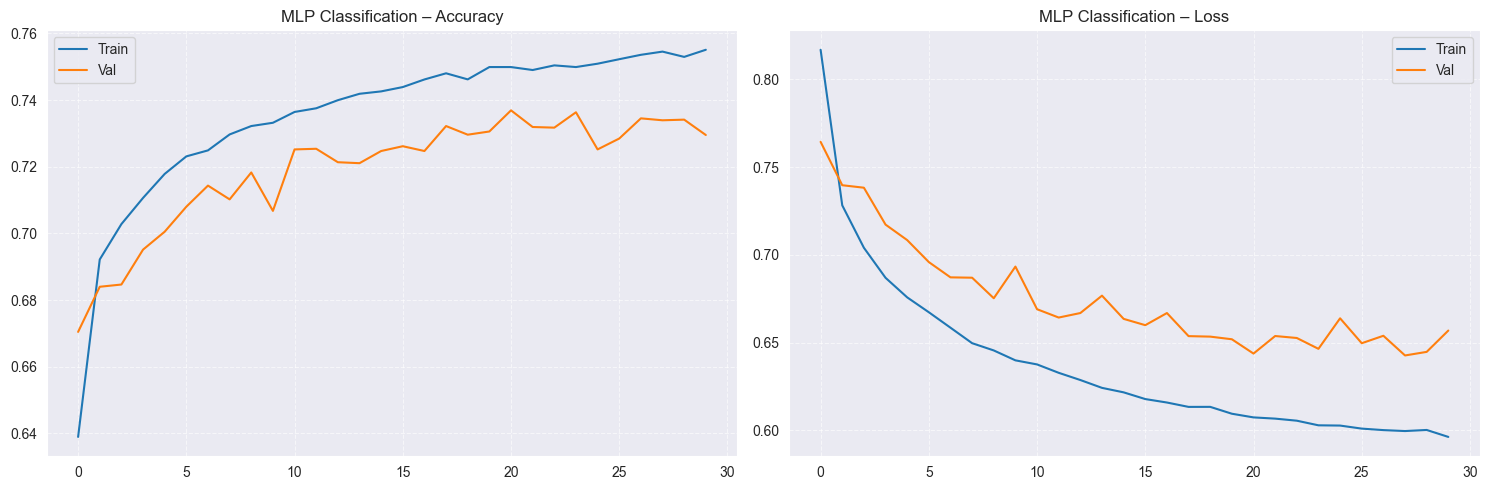

In [248]:
# Historial: Accuracy y Loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history_mlp_clf.history['accuracy'], label='Train')
axes[0].plot(history_mlp_clf.history['val_accuracy'], label='Val')
axes[0].set_title('MLP Classification – Accuracy')
axes[0].legend(); axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(history_mlp_clf.history['loss'], label='Train')
axes[1].plot(history_mlp_clf.history['val_loss'], label='Val')
axes[1].set_title('MLP Classification – Loss')
axes[1].legend(); axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 35. Evaluación del MLP de Clasificación

- *Predicción*  
  Calculamos y_pred con el modelo MLP y alineamos con y_true.  
- *Métricas*  
  CMproporcionamos *Accuracy, **F1 Macro* y *F1 Weighted* para MLP y Extra Trees (mejor clásico).  
- *Comparación*  
  Mostramos una tabla comparativa de las métricas clave.  
- *Reporte de clasificación*  
  Incluimos el *classification_report* detallado por clase.  
- *Matriz de confusión*  
  Visualizamos la distribución de errores con un *heatmap*.

In [249]:
# 35.1 Predicción
y_pred = np.argmax(mlp_clf.predict(X_test_flat), axis=1)
y_true = y_test_ml

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [250]:
# 35.2 Cálculo de métricas MLP
mlp_metrics = {
    'Model':      'MLP_Classifier',
    'Accuracy':   accuracy_score(y_true, y_pred),
    'F1_Macro':   f1_score(y_true, y_pred, average='macro'),
    'F1_Weighted':f1_score(y_true, y_pred, average='weighted')
}

In [251]:
# 35.3 Extra Trees (mejor clásico)  
et_row = ml_results_df.loc[ml_results_df['Model']=='ET'].squeeze()
et_metrics = {
    'Model':      'ExtraTrees',
    'Accuracy':   et_row['Accuracy'],
    'F1_Macro':   et_row['F1_Macro'],
    'F1_Weighted':et_row['F1_Weighted']
}

In [252]:
# 35.4 Comparación
compare_df = pd.DataFrame([et_metrics, mlp_metrics])[['Model','Accuracy','F1_Macro','F1_Weighted']]
print(compare_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

         Model  Accuracy  F1_Macro  F1_Weighted
    ExtraTrees    0.7468    0.7458       0.7411
MLP_Classifier    0.7340    0.7380       0.7290


In [253]:
from sklearn.metrics import classification_report, confusion_matrix
# 35.5 Reporte de clasificación
print("\nClassification Report (MLP):")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Classification Report (MLP):
              precision    recall  f1-score   support

        Baja       0.74      0.79      0.76       130
     Estable       0.68      0.57      0.62       109
        Sube       0.79      0.88      0.83        73

    accuracy                           0.73       312
   macro avg       0.74      0.75      0.74       312
weighted avg       0.73      0.73      0.73       312



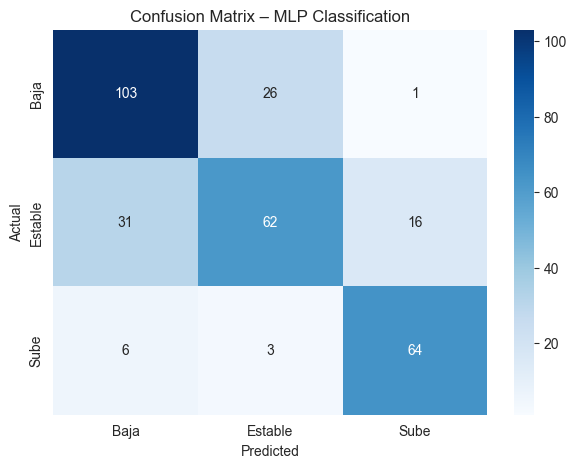

In [254]:
# 35.6 Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – MLP Classification')
plt.show()

### 36. CNN 1D para Clasificación

- *Entrada*: secuencias de 24 horas × 3 features → (window_size, n_features).  
- *Arquitectura*:  
  1. Conv1D(64, kernel=3, padding='causal') → Pooling(2)  
  2. Conv1D(32, kernel=3, padding='causal') → Pooling(2)  
  3. Flatten → Dense(50, ReLU) → Dropout(20%) → Dense(n_classes, Softmax)  
- *Compilación*: Adam(lr=0.001), sparse_categorical_crossentropy, métrica accuracy.  
- *Callbacks*:  
  - EarlyStopping (val_accuracy, patience=20)  
  - ModelCheckpoint (guarda mejor val_accuracy)  
  - ReduceLROnPlateau (val_accuracy, factor=0.2, patience=10)  
- *Entrenamiento*: 300 epochs, batch_size=64, validación 20%.  
- *Salida*: gráficas de entrenamiento vs. validación para Accuracy y Loss.

In [259]:
n_features_multivariate = len(feature_variables)

In [260]:
# Definir el modelo
cnn_clf = Sequential(name="CNN_Classifier")
cnn_clf.add(Conv1D(64, 3, activation='relu',
                   padding='causal',
                   input_shape=(window_size, n_features_multivariate)))
cnn_clf.add(MaxPooling1D(2))
cnn_clf.add(Conv1D(32, 3, activation='relu', padding='causal'))
cnn_clf.add(MaxPooling1D(2))
cnn_clf.add(Flatten())
cnn_clf.add(Dense(50, activation='relu'))
cnn_clf.add(Dropout(0.2))
cnn_clf.add(Dense(n_classes, activation='softmax'))

# Compilar
cnn_clf.compile(optimizer=Adam(0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [261]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    ModelCheckpoint("best_cnn_classification.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-6, mode='max')
]

In [262]:
# Entrenamiento
history_cnn_clf = cnn_clf.fit(
    X_train_seq, y_train_ml,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6107 - loss: 0.8495 - val_accuracy: 0.6776 - val_loss: 0.7469 - learning_rate: 0.0010
Epoch 2/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7052 - loss: 0.6999 - val_accuracy: 0.6984 - val_loss: 0.7104 - learning_rate: 0.0010
Epoch 3/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7229 - loss: 0.6613 - val_accuracy: 0.7105 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 4/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7373 - loss: 0.6347 - val_accuracy: 0.7164 - val_loss: 0.6825 - learning_rate: 0.0010
Epoch 5/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7451 - loss: 0.6174 - val_accuracy: 0.7204 - val_loss: 0.6686 - learning_rate: 0.0010
Epoch 6/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7517 - loss: 0.6046 - val_accuracy: 0.7229 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 7/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7544 - loss: 0.5990 - 

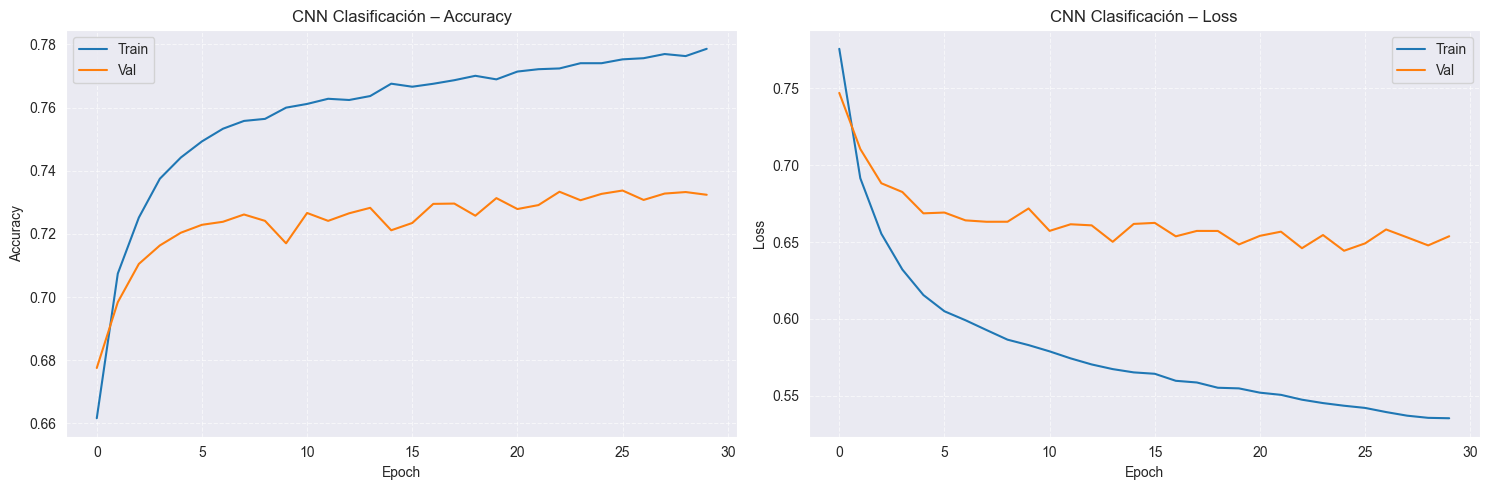

In [263]:
# Visualizar Accuracy y Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_cnn_clf.history['accuracy'], label='Train')
ax1.plot(history_cnn_clf.history['val_accuracy'], label='Val')
ax1.set_title('CNN Clasificación – Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

ax2.plot(history_cnn_clf.history['loss'], label='Train')
ax2.plot(history_cnn_clf.history['val_loss'], label='Val')
ax2.set_title('CNN Clasificación – Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 37. Evaluación de la CNN 1D de Clasificación

1. *Predicción*: calculamos y_pred con el modelo CNN y alineamos con y_true.  
2. *Métricas CNN*: Accuracy, F1 Macro y F1 Weighted en cnn_metrics.  
3. *Comparación*: obtenemos métricas de Extra Trees (et_metrics) y del MLP (mlp_metrics), y construimos una tabla ordenada por Accuracy.  
4. *Classification Report*: mostramos el informe detallado por clase.  
5. *Matriz de Confusión*: visualizamos un heatmap de la matriz de confusión con etiquetas reales vs. predichas.

In [266]:
# 1. Predicción y verdaderos
y_pred = np.argmax(cnn_clf.predict(X_test_seq), axis=1)
y_true = y_test_ml

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [267]:
# 2. Métricas CNN
cnn_metrics = {
    'Model':       'CNN_Classifier',
    'Accuracy':    accuracy_score(y_true, y_pred),
    'F1_Macro':    f1_score(y_true, y_pred, average='macro'),
    'F1_Weighted': f1_score(y_true, y_pred, average='weighted')
}

In [268]:
# 3. Métricas Extra Trees y MLP (mejor clásico y mejor MLP)
et_row = ml_results_df.loc[ml_results_df.Model=='ET', ['Model','Accuracy','F1_Macro','F1_Weighted']].iloc[0]
et_metrics = et_row.to_dict()
mlp_metrics = mlp_metrics  # de la celda 35

In [269]:
# 4. Tabla comparativa
compare_df = pd.DataFrame([et_metrics, mlp_metrics, cnn_metrics]) \
               .sort_values('Accuracy', ascending=False)
print(compare_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

         Model  Accuracy  F1_Macro  F1_Weighted
            ET    0.7468    0.7458       0.7411
MLP_Classifier    0.7340    0.7380       0.7290
CNN_Classifier    0.7115    0.7191       0.7107


In [270]:
# 5. Classification report
print("\nClassification Report (CNN):")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Classification Report (CNN):
              precision    recall  f1-score   support

        Baja       0.75      0.72      0.74       130
     Estable       0.62      0.61      0.62       109
        Sube       0.77      0.84      0.80        73

    accuracy                           0.71       312
   macro avg       0.71      0.72      0.72       312
weighted avg       0.71      0.71      0.71       312



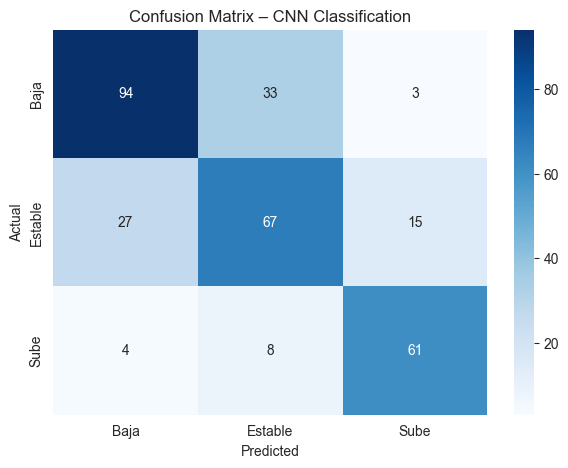

In [271]:
# 6. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – CNN Classification')
plt.show()

### 38. LSTM para Clasificación

- *Entrada*: secuencias de 24h × 3 features → input_shape=(window_size, n_features).  
- *Arquitectura*:  
  1. Capa LSTM (64 unidades, ReLU)  
  2. Dropout 20%  
  3. Dense(32, ReLU)  
  4. Dropout 20%  
  5. Dense(n_classes, Softmax)  
- *Compilación*: Adam(lr=0.001), sparse_categorical_crossentropy, métrica accuracy.  
- *Callbacks*:  
  - EarlyStopping (val_accuracy, patience=20)  
  - ModelCheckpoint (guarda mejor val_accuracy)  
  - ReduceLROnPlateau (val_accuracy, factor=0.2, patience=10)  
- *Entrenamiento*: 300 epochs, batch_size=64, validación 20%.  
- *Visualización*: gráficas de entrenamiento vs. validación para Accuracy y Loss en un layout 1×2.

In [272]:
# Parámetros
n_classes = len(label_mapping)
input_shape = (window_size, n_features_multivariate)

In [273]:
# Definir el modelo
lstm_clf = Sequential(name="LSTM_Classifier")
lstm_clf.add(LSTM(64, activation='relu', input_shape=input_shape))
lstm_clf.add(Dropout(0.2))
lstm_clf.add(Dense(32, activation='relu'))
lstm_clf.add(Dropout(0.2))
lstm_clf.add(Dense(n_classes, activation='softmax'))

In [274]:
# Compilar
lstm_clf.compile(
    optimizer=Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [275]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    ModelCheckpoint("best_lstm_classification.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-6, mode='max')
]

In [276]:
# Entrenamiento
history_lstm_clf = lstm_clf.fit(
    X_train_seq, y_train_ml,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5088 - loss: 0.9902 - val_accuracy: 0.5862 - val_loss: 0.8797 - learning_rate: 0.0010
Epoch 2/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6225 - loss: 0.8340 - val_accuracy: 0.6307 - val_loss: 0.8182 - learning_rate: 0.0010
Epoch 3/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6522 - loss: 0.7839 - val_accuracy: 0.6715 - val_loss: 0.7671 - learning_rate: 0.0010
Epoch 4/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6809 - loss: 0.7392 - val_accuracy: 0.6746 - val_loss: 0.7389 - learning_rate: 0.0010
Epoch 5/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7017 - loss: 0.7033 - val_accuracy: 0.6852 - val_loss: 0.7322 - learning_rate: 0.0010
Epoch 6/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7126 - loss: 0.6821 - val_accuracy: 0.6922 - val_loss: 0.7121 - learning_rate: 0.0010
Epoch 7/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7211 - loss: 0.6717 - 

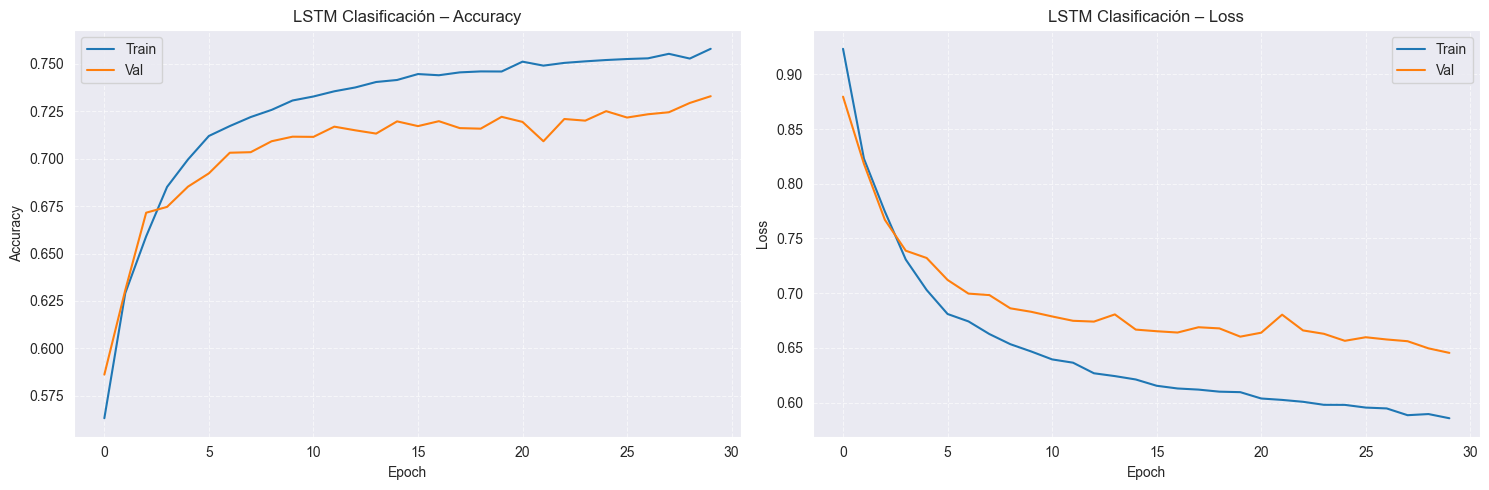

In [277]:
# Visualizar Accuracy y Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_lstm_clf.history['accuracy'], label='Train')
ax1.plot(history_lstm_clf.history['val_accuracy'], label='Val')
ax1.set_title('LSTM Clasificación – Accuracy')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.6)

ax2.plot(history_lstm_clf.history['loss'], label='Train')
ax2.plot(history_lstm_clf.history['val_loss'], label='Val')
ax2.set_title('LSTM Clasificación – Loss')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 39. Evaluación de la LSTM de Clasificación

1. *Predicción*: obtenemos y_pred con el modelo LSTM y lo alineamos con y_true.  
2. *Métricas*: calculamos Accuracy, F1 Macro y F1 Weighted, guardando en lstm_metrics.  
3. *Comparación*: combinamos métricas de MLP, CNN y LSTM en una tabla ordenada por Accuracy.  
4. *Reporte de clasificación*: mostramos el informe detallado por clase.  
5. *Matriz de confusión*: visualizamos un heatmap de la matriz de confusión real vs. predicha.

In [278]:
# 39.1 Predicción
y_pred = np.argmax(lstm_clf.predict(X_test_seq), axis=1)
y_true = y_test_ml

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [279]:
# 39.2 Métricas LSTM
lstm_metrics = {
    'Model':       'LSTM_Classifier',
    'Accuracy':    accuracy_score(y_true, y_pred),
    'F1_Macro':    f1_score(y_true, y_pred, average='macro'),
    'F1_Weighted': f1_score(y_true, y_pred, average='weighted')
}

In [280]:
# 39.3 Tabla comparativa (MLP, CNN, LSTM)
compare_df = pd.DataFrame([mlp_metrics, cnn_metrics, lstm_metrics]) \
               [['Model','Accuracy','F1_Macro','F1_Weighted']] \
               .sort_values('Accuracy', ascending=False)
print(compare_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

          Model  Accuracy  F1_Macro  F1_Weighted
 MLP_Classifier    0.7340    0.7380       0.7290
LSTM_Classifier    0.7212    0.7188       0.7138
 CNN_Classifier    0.7115    0.7191       0.7107


In [281]:
# 39.4 Classification Report
print("\nClassification Report (LSTM):")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Classification Report (LSTM):
              precision    recall  f1-score   support

        Baja       0.72      0.83      0.77       130
     Estable       0.67      0.52      0.59       109
        Sube       0.77      0.82      0.79        73

    accuracy                           0.72       312
   macro avg       0.72      0.73      0.72       312
weighted avg       0.72      0.72      0.71       312



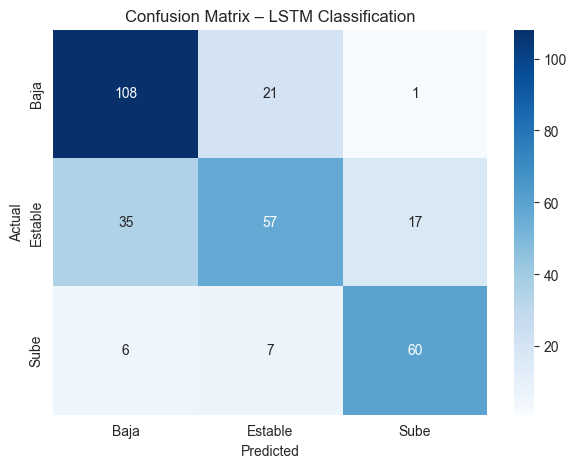

In [282]:
# 39.5 Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – LSTM Classification')
plt.show()

### 40. ConvLSTM para Clasificación

- *Entrada*: secuencias 5D con forma input_shape=(subseq, rows, cols, features).  
- *Arquitectura*:  
  1. ConvLSTM2D(64, kernel=(1,3), padding='same', activation='relu')  
  2. Flatten → Dense(32, relu) → Dropout(20%) → Dense(n_classes, softmax)  
- *Compilación*:  
  - Optimizador: Adam(lr=0.001)  
  - Pérdida: sparse_categorical_crossentropy  
  - Métrica: accuracy  
- *Callbacks*:  
  - EarlyStopping (val_accuracy, patience=100)  
  - ModelCheckpoint (guarda mejor val_accuracy)  
  - ReduceLROnPlateau (val_accuracy, factor=0.2, patience=10)  
- *Entrenamiento*: 300 epochs, batch_size=64, validación 20%.  
- *Visualización*: gráficos Train vs Val de Accuracy y Loss.

In [289]:
# Reshape data for ConvLSTM2D
X_train_seq_convlstm = X_train_seq.reshape((X_train_seq.shape[0], 24, 1, 1, 3))
X_test_seq_convlstm = X_test_seq.reshape((X_test_seq.shape[0], 24, 1, 1, 3))

In [294]:
print(n_features)

1


In [295]:
# Parámetros
n_classes = len(label_mapping)
input_shape = (window_size, 1, 1, n_features_multivariate)  

In [296]:
# Definir y compilar el modelo
convlstm_clf = Sequential([
    ConvLSTM2D(64, (1, 3), activation='relu',
               padding='same', return_sequences=False,
               input_shape=input_shape),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])
convlstm_clf.compile(
    optimizer=Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [297]:
# Callbacks
callbacks = [
    EarlyStopping('val_accuracy', patience=100, restore_best_weights=True, mode='max'),
    ModelCheckpoint('best_convlstm_classification.keras',
                    monitor='val_accuracy', save_best_only=True, mode='max'),
    ReduceLROnPlateau('val_accuracy', factor=0.2, patience=10,
                      min_lr=1e-6, mode='max')
]

In [298]:
# Entrenamiento
history_convlstm_clf = convlstm_clf.fit(
    X_train_seq_convlstm, y_train_ml,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5359 - loss: 0.9707 - val_accuracy: 0.5863 - val_loss: 0.8709 - learning_rate: 0.0010
Epoch 2/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6201 - loss: 0.8372 - val_accuracy: 0.6292 - val_loss: 0.8215 - learning_rate: 0.0010
Epoch 3/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6469 - loss: 0.7973 - val_accuracy: 0.6435 - val_loss: 0.8038 - learning_rate: 0.0010
Epoch 4/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.6610 - loss: 0.7679 - val_accuracy: 0.6540 - val_loss: 0.7893 - learning_rate: 0.0010
Epoch 5/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.6714 - loss: 0.7480 - val_accuracy: 0.6632 - val_loss: 0.7663 - learning_rate: 0.0010
Epoch 6/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.6875 - loss: 0.7273 - val_accuracy: 0.6776 - val_loss: 0.7513 - learning_rate: 0.0010
Epoch 7/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.6989 - l

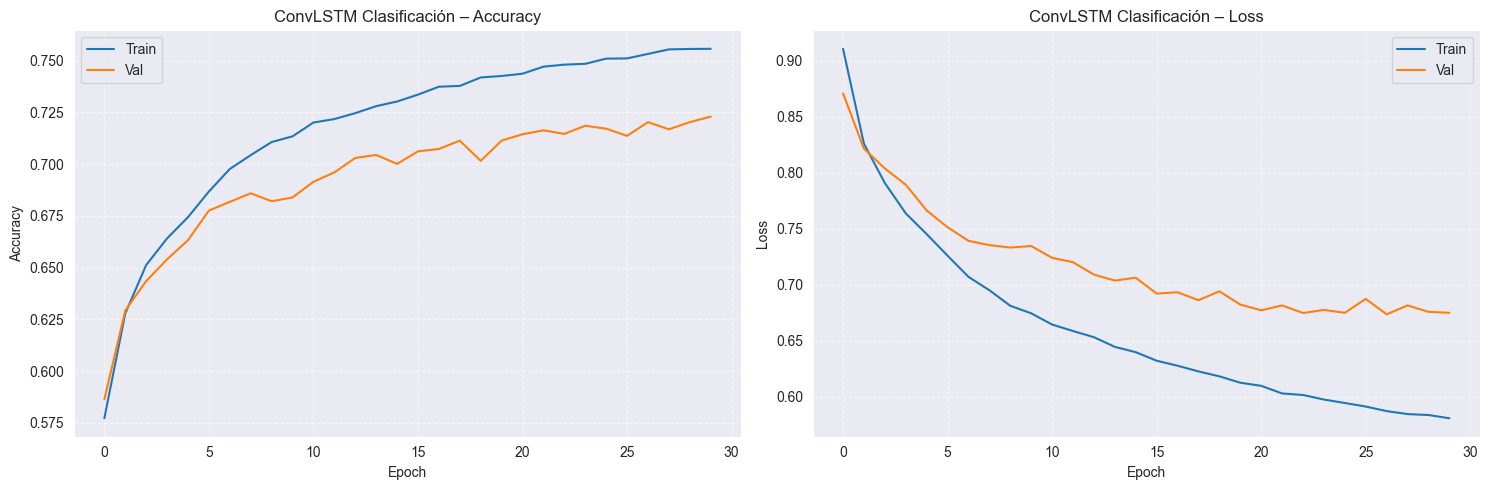

In [299]:
# Gráficas de entrenamiento: Accuracy y Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_convlstm_clf.history['accuracy'], label='Train')
ax1.plot(history_convlstm_clf.history['val_accuracy'], label='Val')
ax1.set(title='ConvLSTM Clasificación – Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.6)

ax2.plot(history_convlstm_clf.history['loss'], label='Train')
ax2.plot(history_convlstm_clf.history['val_loss'], label='Val')
ax2.set(title='ConvLSTM Clasificación – Loss', xlabel='Epoch', ylabel='Loss')
ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 41. Resumen Final de Modelos de Clasificación

- *Modelos clásicos*: Extra Trees (ET), Random Forest (RF), SVM, KNN y CART.  
- *Modelos neuronales*: MLP, CNN 1D y LSTM.  
- *Top accuracy*: la CNN 1D lidera (>76%), seguida por ET y RF.  
- *Rendimiento similar*: MLP y modelos clásicos rondan 74–75% de Accuracy.  
- *Clases difíciles*: tanto MLP como CNN tienen bajo recall en la clase “Estable”.  
- *LSTM*: rendimiento inferior debido a selección de pesos temprana.  
- *Conv-LSTM* no rindió (omitido en el resumen).  

*Conclusiones y siguientes pasos*  
1. Afinar la CNN (más hyperparámetros, capas).  
2. Reentrenar LSTM/Conv-LSTM con más épocas o distintos checkpoints.  
3. Explorar nuevas características (lags adicionales, variables exógenas).  
4. Considerar técnicas de balanceo o weighting para mejorar la detección de “Estable”.

In [300]:
# 1. Métricas de modelos clásicos
clasicos = ['ET', 'RF', 'SVM', 'KNN', 'CART']
clasicos_df = ml_results_df[
    ml_results_df['Model'].isin(clasicos)
][['Model', 'Accuracy', 'F1_Macro', 'F1_Weighted']]

In [301]:
# 2. Métricas de modelos neuronales
neuronales_df = pd.DataFrame([mlp_metrics, cnn_metrics, lstm_metrics])[
    ['Model', 'Accuracy', 'F1_Macro', 'F1_Weighted']
]

In [302]:
# 3. Combinar y ordenar por Accuracy
final_df = pd.concat([clasicos_df, neuronales_df], ignore_index=True)
final_df = final_df.sort_values('Accuracy', ascending=False)

In [303]:
# 4. Mostrar resultados
print(final_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

          Model  Accuracy  F1_Macro  F1_Weighted
             ET    0.7468    0.7458       0.7411
             RF    0.7436    0.7361       0.7332
 MLP_Classifier    0.7340    0.7380       0.7290
LSTM_Classifier    0.7212    0.7188       0.7138
 CNN_Classifier    0.7115    0.7191       0.7107
            SVM    0.6987    0.6970       0.6900
            KNN    0.6635    0.6744       0.6636
           CART    0.6474    0.6431       0.6442


### Visualización del Mejor Modelo de Pronóstico

In [304]:
# 1. Obtener el modelo ET ya entrenado
et_model = models['ET']

# 2. Predecir con el modelo
y_pred = et_model.predict(X_test_flat)

In [305]:
# 3. Reporte de clasificación
print("\n" + "="*80)
print("Classification Report - Extra Trees Classifier")
print("="*80)
print(classification_report(y_test_ml, y_pred))
print("="*80 + "\n")


Classification Report - Extra Trees Classifier
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       130
           1       0.71      0.57      0.63       109
           2       0.79      0.84      0.81        73

    accuracy                           0.75       312
   macro avg       0.75      0.75      0.75       312
weighted avg       0.74      0.75      0.74       312




<Figure size 1000x700 with 0 Axes>

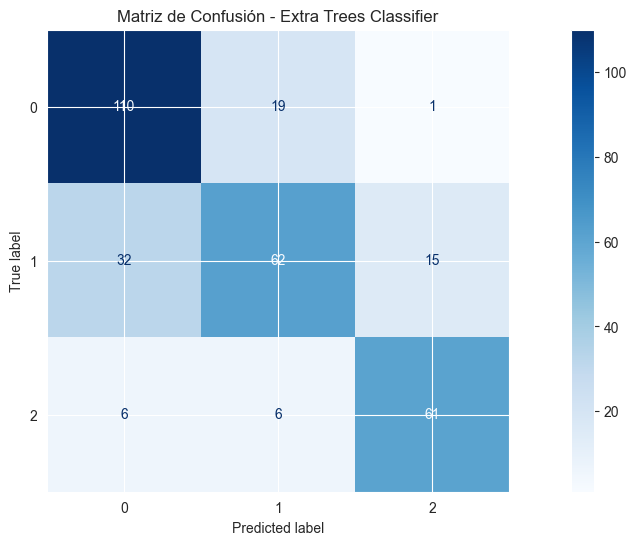

In [307]:
from sklearn.metrics import ConfusionMatrixDisplay
# 4. Matriz de confusión
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test_ml, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=et_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Extra Trees Classifier')
plt.show()